<a href="https://colab.research.google.com/github/K-Chorna02/DST_Assessment_2/blob/main/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction



We focus on Image classification using Convolutional Neural Networks, a widely applicable and impactful use of CNNs with many real-world applications. Image classification is very important in a range of fields including tagging images in social media posts, in search engines such as Google, dietary tracking apps or medical settings.

Our goal is to investigate how different optimisation strategies and model architectures affect classification accuracy and robustness, and to determine which methods generalise best when scaled to more complex and realistic datasets.

Throughout our project we each carried out a related task to learn more about Neural Networks.
We began exploring CIFAR-10, which we treated as a toy dataset due to its low resolution and small number of classes to learn more about optimisation and how the changing of hyperparameters (such as batch size, learning rate and optimizer) affects the performance of models.

We then generalised to a more realistic dataset,(Food 101) where we created commonly seen CNN models from scratch (ResNet18 and ViT models) alongside using transfer learning.
Our choice in models was justified by a literature review and by our limited resources and time constraints, which we discuss in more detail in the ResNet18 and ViT sections of this report.

Food101 was the most appropriate dataset to explore after testing on CIFAR-10 as it was the perfect balance between real-world complexity while also being feasible to work with. We downsampled to a resolution of 64x64 for training purposes.  

Food image classification is increasingly relevant with the growing popularity of dieting apps to track calories and nutrients, which require successful identification of the food in question. The Food101 dataset mirrors this real-world application as the dataset consists of real photos of food uploaded by people across the world.

Finally, we tested their robustness by changing our test sets to make them harder for the model to interpret, e.g. adding Gaussian blur or changing the brightness of our images. This allowed us to examine whether certain architectures were more resilient to visual noise than others, mimicking scenarios that may be seen in a real-world setting.




# Limitations
We faced a few limitations within our project:
- Colab GPU limitations
- Time constraint
- Memory
- Knowledge of Neural Networks

Due to the fact we would be training models over thousands of pieces of data across many epochs, GPUs would be required, so we chose to use Collab for our coding. However, this still only provided us with limited access.

We only had 3 weeks to complete this project, so we had to ensure we had enough time to train our models and evaluate their performance, so we chose our models accordingly so that they would be achievable.

We chose our goal with these in mind.


# Libraries

In [ ]:
#Loading necessary libraries
#general Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

#for EDA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from scipy.stats import entropy
import pandas as pd

#PCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#robustness
import cv2
import random
import os
import requests
from tqdm import tqdm
import time


# About our datasets

## CIFAR-10

The CIFAR-10 dataset can be found online at: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

This is a widely used benchmark dataset created by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton, used for image classification in machine learning methods.

It consists of 60,000 sets of 32x32 images split into 10 classes, such as planes, cars, birds, cats, etc. Of these 50,000 are used for training and the remaining 10,000 are used for testing.
This makes it a perfect starting point for our project, serving as a toy dataset to better understand neural networks. Due to its low resolution, we are able to explore the impacts of different hyperparameters and hence optimise our neural network.

By experimenting and exploring the effects of different optimisation approaches on CIFAR-10, we aim to understand which approaches generalise well before applying them to larger and more complex datasets.
We note some may improve performance specifically on this data set but not generalise so well.

Below we load CIFAR-10:




In [ ]:
batch_size = 10

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Note on these transforms: preprocesses images into a form that the model can work with. For example, converts images to 'tensors' and normalises their pixel values. Normalisation ensures each image has similar intensity ranges so that the model can learn more effectively across different images.

batch size = 10 means: we create subsets of data containing 10 images each. Then have the model learn based off each batch rather than handling the whole dataset at once.

transform pipeline contains:
transforms.ToTensor(): converts images to tensors - a data format that lets us work in PyTorch

transforms.Normalize(...): Normalises / adjusts RGB colour values to have a mean of 0 and standard deviation of 1 for each of the colours (red,green,blue).

the tuples (0.5,0.5,0.5) represent the mean and standard deviation for each colour channel. 0.5 is used because:

1. after applying transforms.ToTensor, the CIFAR-10 dataset has images with pixel values between 0 and 1. We want pixel values centred around 0 for the neural network, so we take 0.5 as the mean and standard deviation, to approximately normalise.

2. 0.5 is close enough to the actual means and standard deviation (rough approximation)

3. Efficiency for training.

**Downloading and loading CIFAR-10 Dataset**

In [ ]:
#downloading
print("Downloading training data...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

print("Downloading testing data...")
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

#info
print(f"Training samples: {len(trainset)}")
print(f"Testing samples: {len(testset)}")
print(f"Classes: {trainset.classes}")


100%|██████████| 170M/170M [00:02<00:00, 71.6MB/s]


Training samples: 50000
Testing samples: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Then DataLoader streamlines the process of feeding images to the model:

First puts data into batches of 10 images. Using batches instead of individual images is quicker for updating model weights.

Shuffle = True means each batch of images is randomised. This means model generalises better, makes it less likely model overfits to any specific order of images (e.g if the dataset first had 20 images of bird, then 20 of plane etc.)

num_workers = 2 sets number of CPU threads used for data loading.

Now we've loaded the data and we can see the names of the 10 classes and the number of test vs training samples, we can now visualise a small sample (10 images) of the data:

**Defining Classes**

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

**Loading a batch of training images**

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter) #slight modification here to account for python update (code from article crashes here otherwise)

The above creates an iterator for the trainloader and then retreives next batch of images and labels.

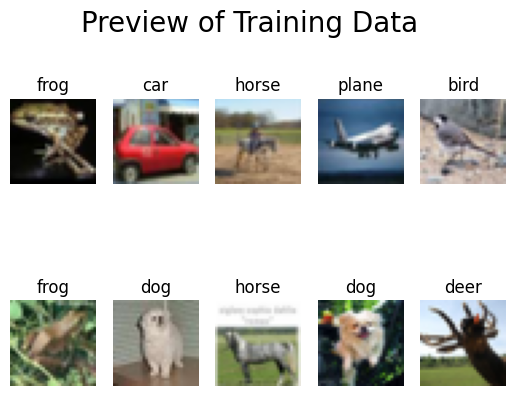

In [ ]:
for i in range(batch_size):
    plt.subplot(2, int(batch_size/2), i + 1) #creates subplots
    img = images[i] #extracts each image
    img = img / 2 + 0.5 #undoes normalisation to restore original colour range
    npimg = img.numpy() #convert tensor to numpy array so we can plot with matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #adjusts image dimensions (SEE CELL BELOW)
    plt.axis('off')
    plt.title(classes[labels[i]]) #labels subplots

plt.suptitle('Preview of Training Data', size=20)
plt.show()

Note on adjusting image dimensions: Pytorch images are in the format (channels, height, width) but matplotlib works with the format (height, width, channels). The transpose function deals with this.

We check to see how many images for each class:

In [ ]:
from collections import Counter
labels = [label for _, label in trainset]
label_counts = Counter(labels)

for idx, count in label_counts.items():
    print(f"{trainset.classes[idx]}: {count}")

print(images.shape)

frog: 5000
truck: 5000
deer: 5000
automobile: 5000
bird: 5000
horse: 5000
ship: 5000
cat: 5000
dog: 5000
airplane: 5000
torch.Size([10, 3, 32, 32])


Since this dataset has been collected in an artificial environment and transformed, we know that there is an even class distribution with all images having the same 32x32 pixel dimensions.

Since we are exploring how different model architectures perform against one another, the CIFAR-10 is reasonably small whilst still containing images that are somewhat complex, making it appropriate for our initial explorations before we scale to larger datasets. The 32x32 dimensions of the CIFAR-10 dataset means it is quicker to run when we are limited by GPU resources.

###EDA on CIFAR-10
Exploratory data analysis allows us to gain more information about our dataset. We find the mean and standard deviations of our colour channels, explore how these vary for each class, and consider the entropy of our dataset.

#### Mean and std of channels
We can obtain information about the mean and standard deviation of the colour channels:

In [ ]:
all_pixels = torch.cat([images.view(-1, 3) for images, _ in trainloader], dim=0)

print(all_pixels.mean(dim=0))#mean
print(all_pixels.std(dim=0))#std
#this gives us the mean and std for each channel of RGB.

class_means = {}
class_stds = {}

for cls in range(10):
    pixels = []
    for images, labels in trainloader:
        cls_images = images[labels == cls]#selecting only images of this class
        if len(cls_images) == 0:
            continue
        pixels.append(cls_images.view(-1, 3))

    pixels = torch.cat(pixels, dim=0)
    class_means[cls] = pixels.mean(dim=0)
    class_stds[cls] = pixels.std(dim=0)

print(class_means)
print(class_stds)


tensor([-0.0533, -0.0533, -0.0533])
tensor([0.5031, 0.5031, 0.5032])
{0: tensor([0.1165, 0.1166, 0.1167]), 1: tensor([-0.0847, -0.0847, -0.0847]), 2: tensor([-0.0635, -0.0634, -0.0636]), 3: tensor([-0.0883, -0.0884, -0.0884]), 4: tensor([-0.1233, -0.1233, -0.1234]), 5: tensor([-0.0792, -0.0792, -0.0793]), 6: tensor([-0.1642, -0.1642, -0.1643]), 7: tensor([-0.0675, -0.0675, -0.0676]), 8: tensor([0.0468, 0.0469, 0.0470]), 9: tensor([-0.0253, -0.0253, -0.0252])}
{0: tensor([0.5078, 0.5077, 0.5078]), 1: tensor([0.5396, 0.5396, 0.5397]), 2: tensor([0.4655, 0.4655, 0.4656]), 3: tensor([0.5156, 0.5156, 0.5156]), 4: tensor([0.4324, 0.4323, 0.4323]), 5: tensor([0.5001, 0.5001, 0.5002]), 6: tensor([0.4578, 0.4578, 0.4578]), 7: tensor([0.4978, 0.4978, 0.4978]), 8: tensor([0.4975, 0.4974, 0.4974]), 9: tensor([0.5458, 0.5458, 0.5459])}


As we can see, the mean and std for each of the RGB colour channels are very even. We looked at the RGB distribution for each class to see if one had a larger presence of one colour than the other, which may affect the way the model learns to predict certain colours, but we see these are very similar, making this a very useful dataset.

#### Statistical pixel analysis

We can also carry out a statistical pixel analysis for each channel of our dataset:

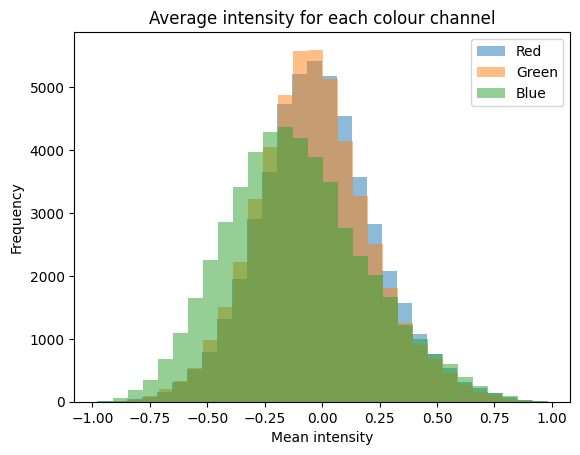

In [ ]:
r_means, g_means, b_means = [], [], []#red, green, blue
for images, _ in trainloader: #we loop through the dataset in batches
    r_channel = images[:, 0, :, :]
    g_channel = images[:, 1, :, :]
    b_channel = images[:, 2, :, :]

    r_np = r_channel.numpy()
    g_np = g_channel.numpy()
    b_np = b_channel.numpy()
#then comoute means after numpy
    for i in range(r_np.shape[0]):
        r_means.append(np.mean(r_np[i]))
        g_means.append(np.mean(g_np[i]))
        b_means.append(np.mean(b_np[i]))

plt.hist(r_means, bins=30, alpha=0.5, label='Red')
plt.hist(g_means, bins=30, alpha=0.5, label='Green')
plt.hist(b_means, bins=30, alpha=0.5, label='Blue')
plt.legend()
plt.title("Average intensity for each colour channel")
plt.xlabel("Mean intensity")
plt.ylabel("Frequency")
plt.show()


The above plot shows that each of the colours are centred around 0, suggesting similar colour distributions across all images. This shows our dataset is well balanced and diverse in terms of colours.


#### PCA
We can apply Principal Component Analysis, a dimensionality reduction method that projects high-dimensional image data onto a lower-dimensional space while preserving as much variance as possible. This allows us to visualise key variance patterns across our dataset.

Since our CIFAR-10 data is composed of 32x32 pixels, so each image becomes a 3072-dimensional feature vector once flattened. Using PCA, we can visualise this in 2D while capturing dominant patterns of variation across images.

However, PCA treats all pixels as independent features and ignores the spatial structure, meaning we can't use this to fully capture the true representational complexity of image data. However, it is a useful tool to get an overview variation across the dataset.

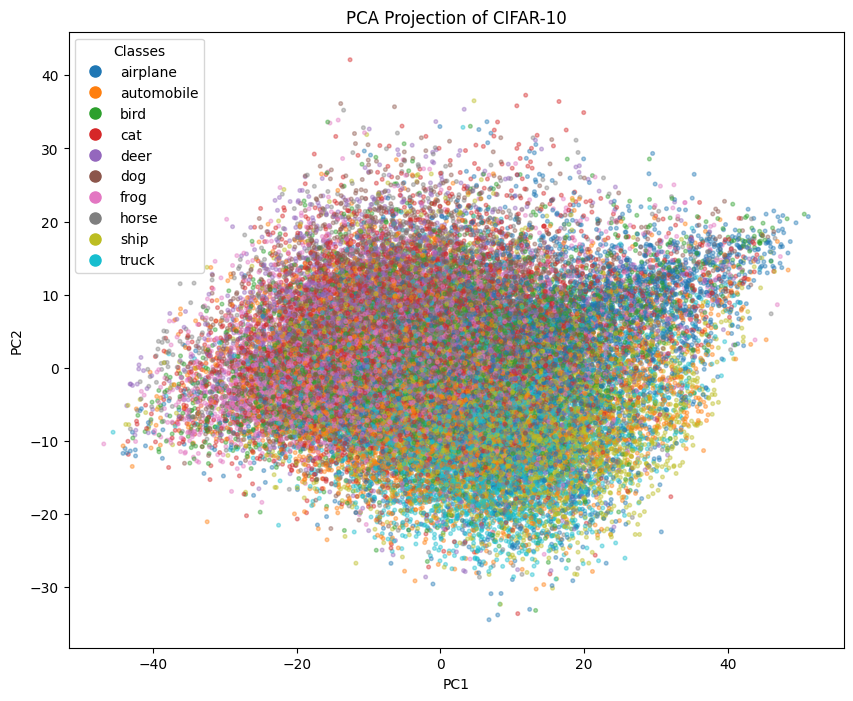

In [ ]:
trainloader_PCA = torch.utils.data.DataLoader(
    trainset, batch_size=len(trainset), shuffle=False
)


images, labels = next(iter(trainloader_PCA))
X = images.reshape(images.shape[0], -1).cpu().numpy()#flatten
y = labels.cpu().numpy()
pca = PCA(n_components=2)#2D
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=y, cmap="tab10",
    s=7, alpha=0.4
)

class_names = trainset.classes
colors = plt.cm.tab10(np.linspace(0, 1, 10))

handles = [
    plt.Line2D([], [], marker='o', color=colors[i], linestyle='', markersize=8)
    for i in range(10)
]

plt.legend(handles, class_names, title="Classes", fontsize=10)

plt.title("PCA Projection of CIFAR-10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()



The plot of PCA shows us that some variation was captured by the principal components, since there is some loose structure in the points when projected along the two principal component axis.

However, the classes were not clearly separable in 2D PCA space. This is to be expected from PCA and aligns with existing literature, as it struggles to clearly distinguish classes.

#### Entropy

Entropy is essentially a metric for the average amount of information contained in the image.
We use it to measure how unpredictable or random a distribution is [5].
So in the context of our image classification, this is a measure of how varied the pixel intensities are. The final entropy value is the average entropy across all three RGB channels.

We use Shannon entropy, defined as follows:

$H(X)=-\sum^n_{i=1} p_i log(p_i)$

Where $p_i$ represents the probability of the i-th pixel intensity value. For our dataset, we treat each colour channel (RGB) as a separate probability distribution. We estimate this distribution by computing a histogram of pixel intensities, normalise it to obtain probabilities, and then compute entropy for each channel.

Images with high entropy are hard to compress since they contain lots of detail, those with low entropy have smoother regions.

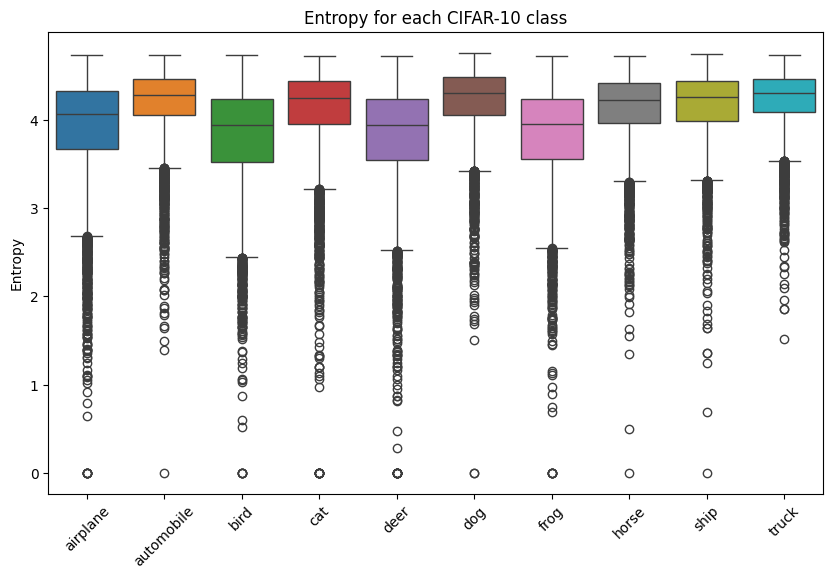

In [ ]:

def image_entropy(img):
    img = img.squeeze()
    entropies = []

    for c in range(3):
        channel = img[c].flatten()
        hist = torch.histc(channel, bins=256, min=0.0, max=1.0)
        if hist.sum() == 0:
            continue
        hist = hist / hist.sum()
        entropies.append(entropy(hist.cpu().numpy() + 1e-8))

    if len(entropies) == 0:
        return 0
    return sum(entropies) / len(entropies)
class_entropies = {c: [] for c in trainset.classes}

for imgs, labels in trainloader:
    for img, label in zip(imgs, labels):
        e = image_entropy(img)
        class_entropies[trainset.classes[label]].append(e)
plt.figure(figsize=(10,6))
sns.boxplot(data=list(class_entropies.values()))
plt.xticks(range(10), trainset.classes, rotation=45)
plt.ylabel("Entropy")
plt.title("Entropy for each CIFAR-10 class")
plt.show()



From our entropy boxplots we can see that all CIFAR-10 classes have similar entropy values, suggesting similar image complexity across our dataset.
Some classes such as automobile, cat, dog, show slightly higher entropy values, perhaps because of more complex textures or backgrounds that may feature in these images.

Airplane, bird and bard have lower entropy values, most likely due to the simple background of the sky (smooth, mostly one colour). Frog and deer also have slightly lower values, perhaps beacuse they often appear against uniform green or uniform grey (roads) backgrounds rather than a wide variety of very different colours.
We see many lower entropy outliers for evry class, these might represent darker, brighter or more simple images.

We note that entropy by itself will not capture a measure of true complexity, but it is useful to see dataset diversity and which classes contain more information.



## Food 101

The CIFAR-10 is an idealised dataset where images are transformed to make them better suited to image classification. However, this is not reflective of real-world scenarios so we decided to focus on a more complex dataset.

We explored various datasets including TinyImageNet and CIFAR-100, however these datasets were highly complex and hard to distinguish when downsampled for our training purposes. These would have required a larger amount of preprocessing, shifting the focus of the project away from architectural exploration and towards data cleaning.

The Food 101 dataset is a large scale dataset composed of realistic photos taken of different dishes. The data set was compiled by [1] who used images from 'foodspotting.com', a site that allows users to take images of what they are eating, annotate place and type of food, and upload the information online, resulting in this open source dataset.
The creators [1] created this with the aim of using image clasification with different dishes.

Food typically does not exhibit any distinctive spatial layout, unlike images in the CIFAR-10 dataset where an image with a plane often follows expected visual compositions of the sky in the background.
The images themselves are taken from different angles, different lightings, viewpoints and background context.
For this reason we felt this dataset reflected the complexities of real life scenarios.

This dataset consists of 101 food categories, with 101, 000 images. For each class, 250 manually cleaned test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.

This dataset demonstrates a more realistic progression beyond CIFAR-10, allowing us to investigate deeper architectural choices, such as ResNet-18 and ViTs, before comparing model performance under imperfect, real-world conditions.

The data is split in the following way:
- Train: 75,750
- Test: 25,250

Below we import the dataset to get an overview :



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#loading Food-101 dataset
food_root = "data"
train_dataset = datasets.Food101(root=food_root, split="train", download=True)
test_dataset  = datasets.Food101(root=food_root, split="test",  download=True)

print(f"Full train size: {len(train_dataset)}, test size: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")

100%|██████████| 5.00G/5.00G [02:52<00:00, 29.0MB/s]


Full train size: 75750, test size: 25250
Number of classes: 101


Note: The original resolution is 256x256 but due to our limited GPU resources, we downsampled to 64x64 to train our models effectively.

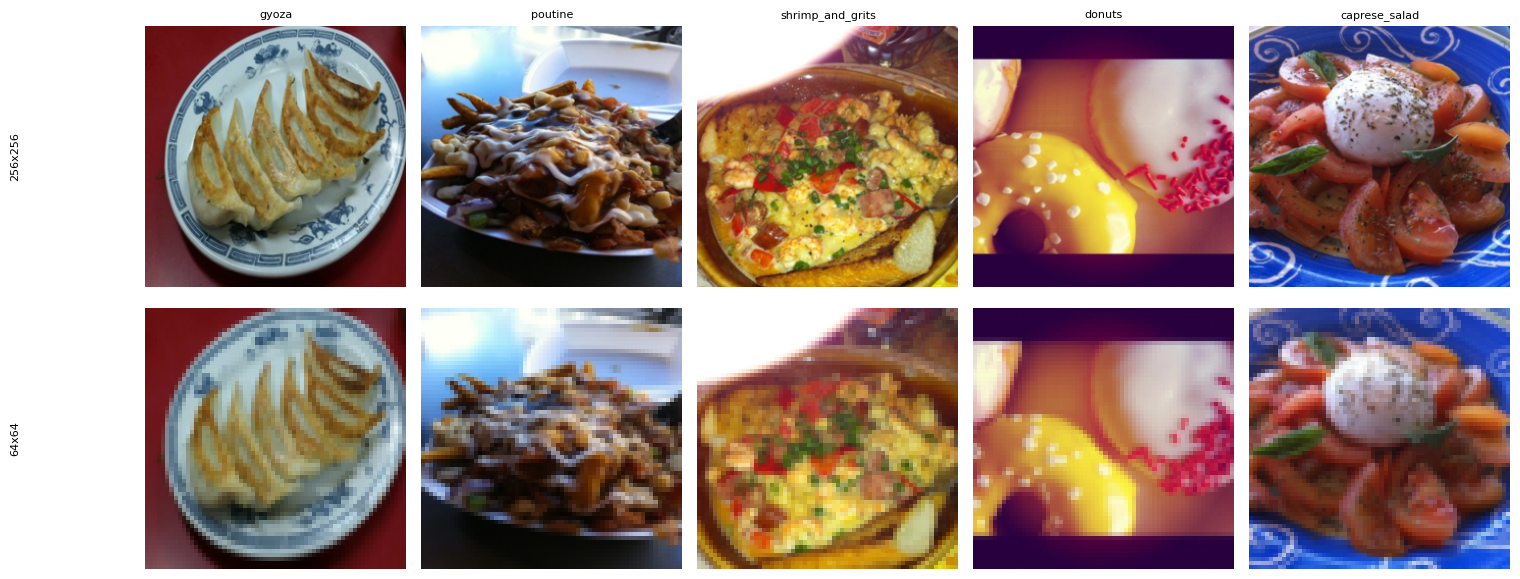

In [ ]:
subset_train_idx = random.sample(range(len(train_dataset)), 5)  # pick 5 random images
train_subset = Subset(train_dataset, subset_train_idx)

#we transform to 64x64 from the original 256
resolutions = [256, 64]
transforms_dict = {r: transforms.Compose([transforms.Resize((r,r)), transforms.ToTensor()]) for r in resolutions}
def plot_same_images_with_labels(dataset, resolutions):
    n = len(dataset)  #number of images in subset
    fig, axs = plt.subplots(len(resolutions), n, figsize=(n*3, len(resolutions)*3))

    for j in range(n):
        img, label_idx = dataset[j]
        label = dataset.dataset.classes[label_idx]#to get the class name
        for i, r in enumerate(resolutions):
            img_r = transforms_dict[r](img) #resizing
            img_np = img_r.permute(1,2,0).numpy()
            axs[i,j].imshow(img_np)
            axs[i,j].axis('off')

            if i == 0:
                axs[i,j].set_title(f"{label}", fontsize=8)
            if j == 0:
                axs[i,j].text(-0.5, 0.5, f"{r}x{r}", rotation=90, fontsize=8, va='center', ha='center', transform=axs[i,j].transAxes)
    plt.tight_layout()
    plt.show()

plot_same_images_with_labels(train_subset, resolutions)


In [ ]:
#preparing our test and train
#making 64x64
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])


train_dataset64 = datasets.Food101(root="data", split="train", download=False, transform=transform)
test_dataset64  = datasets.Food101(root="data", split="test",  download=False, transform=transform)

train_loader64 = DataLoader(train_dataset64, batch_size=64, shuffle=True)
test_loader64  = DataLoader(test_dataset64, batch_size=64, shuffle=False)

We can see that reducing the resolution in this way makes the images much harder to identify, but due to limitations in time constraints and GPUs for training, we had to reduce to 64x64 to be able to train our models.

### EDA Food 101
We carry out exploratory data analysis on Food101 to ensure it is the most appropriate dataset.
We test that it is more complex than CIFAR10 but by reducing to 64x64 it makes it feasible to work with.

#### Mean and std of channels

In [ ]:
means, stds = [], [] #mean pixels per channel
for img, _ in train_loader64:

    means.append(img.mean(dim=[0, 2, 3]))
    stds.append(img.std(dim=[0, 2, 3]))

#over all batches
means = torch.stack(means).mean(0)
stds = torch.stack(stds).mean(0)

print("Channel Means:", means)
print("Channel Stds:", stds)


Channel Means: tensor([ 0.2621, -0.0557, -0.2772])
Channel Stds: tensor([1.1381, 1.1705, 1.1865])


Unlike the CIFAR-10 dataset, we get bigger mean differences between RGB colour channels, suggesting that there is a greater dominance of certain colours preseent in some images. This is to be expected since the images are collected in a real world scenario and so there is more diversity in images.

#### Entropy

Unlike entropy for CIFAR-10, we can't produce a plot for all 101 classes, so instead we choose a random sample of 10 of the classes and then plot their entropies.

Sampled classes: ['croque_madame', 'baby_back_ribs', 'apple_pie', 'tuna_tartare', 'carrot_cake', 'beignets', 'macarons', 'shrimp_and_grits', 'oysters', 'fried_calamari']


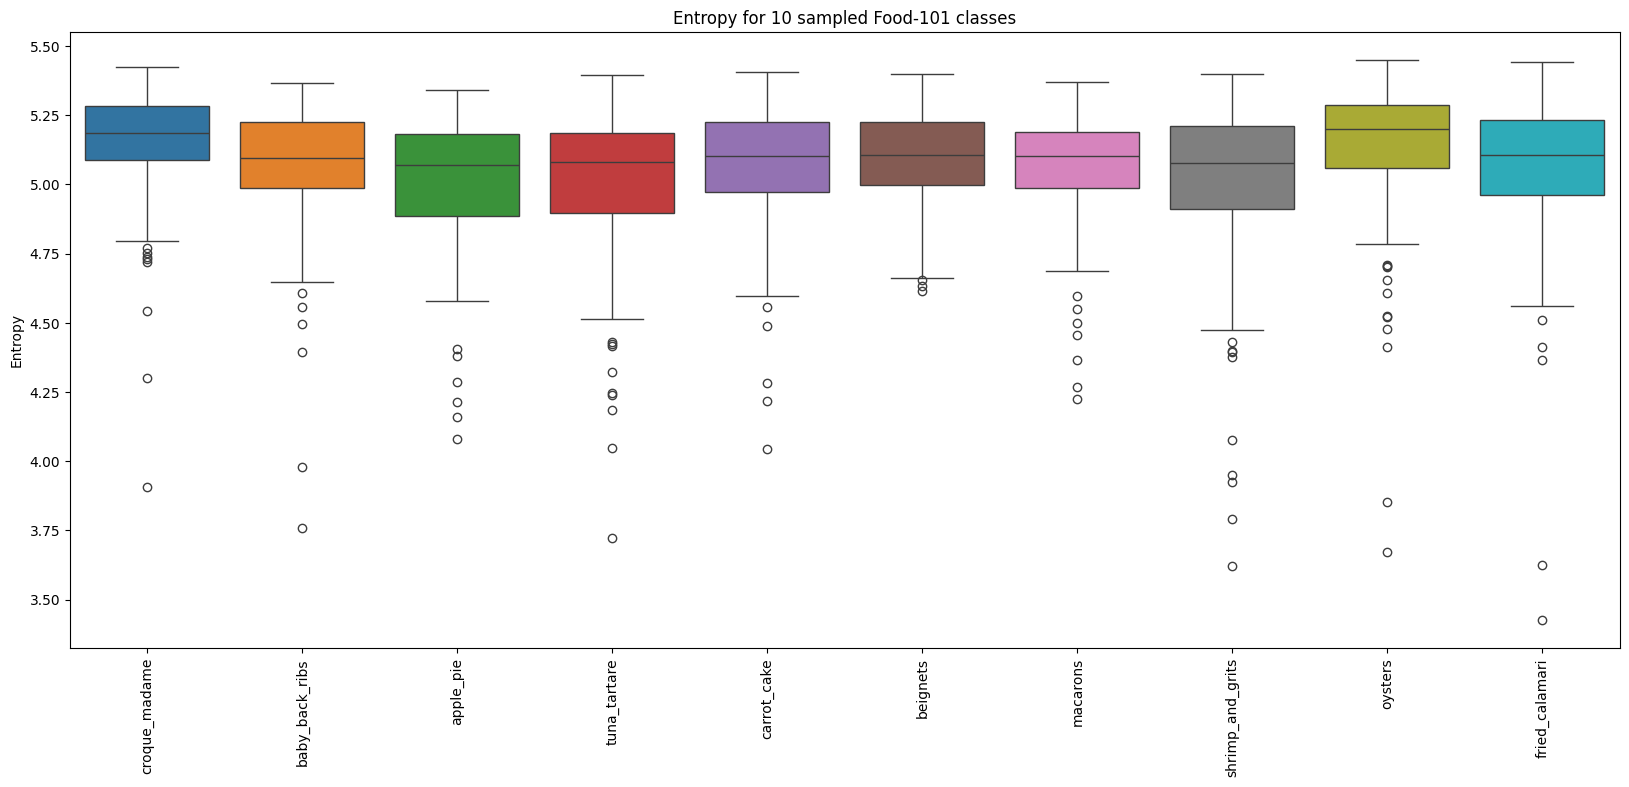

In [ ]:
num_classes_to_sample = 10  #choose 10 random classes
classnames = train_dataset64.classes
sampled_classes = random.sample(classnames, num_classes_to_sample)
print("Sampled classes:", sampled_classes)

def image_entropy(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

    img = img * std + mean
    img = img.clamp(0,1)

    img = img.squeeze()
    entropies = []

    for c in range(3):
        channel = img[c].flatten()
        hist = torch.histc(channel, bins=256, min=0.0, max=1.0)
        hist = hist / hist.sum()
        entropies.append(entropy(hist.cpu().numpy() + 1e-8))

    return sum(entropies) / 3

class_entropies = {cls: [] for cls in sampled_classes}
max_images_per_class = 150
images_count = {cls: 0 for cls in sampled_classes}


for imgs, labels in train_loader64:
    for img, label in zip(imgs, labels):
        cls = classnames[label]

        if cls not in sampled_classes:
            continue

        if images_count[cls] >= max_images_per_class:
            continue

        e = image_entropy(img)
        class_entropies[cls].append(e)
        images_count[cls] += 1

    if all(images_count[c] >= max_images_per_class for c in sampled_classes):
        break

plt.figure(figsize=(20,8))
sns.boxplot(data=list(class_entropies.values()))
plt.xticks(range(num_classes_to_sample), sampled_classes, rotation=90)
plt.ylabel("Entropy")
plt.title(f"Entropy for {num_classes_to_sample} sampled Food-101 classes")
plt.show()


As we expect, we have higher entropy values (median between 5-5.5) for each of our randomly sampled classes for food 101 data compared to CIFAR-10. This is because images contain more natural variation such as real-world backgrounds, different lighting, higher resolution, and more complex textures. Consequently, Food101 has a bigger spread of pixel intensities, increasing entropy. This makes it more generalisable to real world scenarios where we often have complex images.

### PCA
We carry out PCA on Food101, but we note that we choose a smaller sample due to the large number of classes and large amount of data.
We choose 10 classes and 200 images per class for this visualisation.

Sampled Food-101 classes for PCA: ['scallops', 'seaweed_salad', 'spaghetti_bolognese', 'pulled_pork_sandwich', 'takoyaki', 'escargots', 'creme_brulee', 'fried_calamari', 'mussels', 'pho']


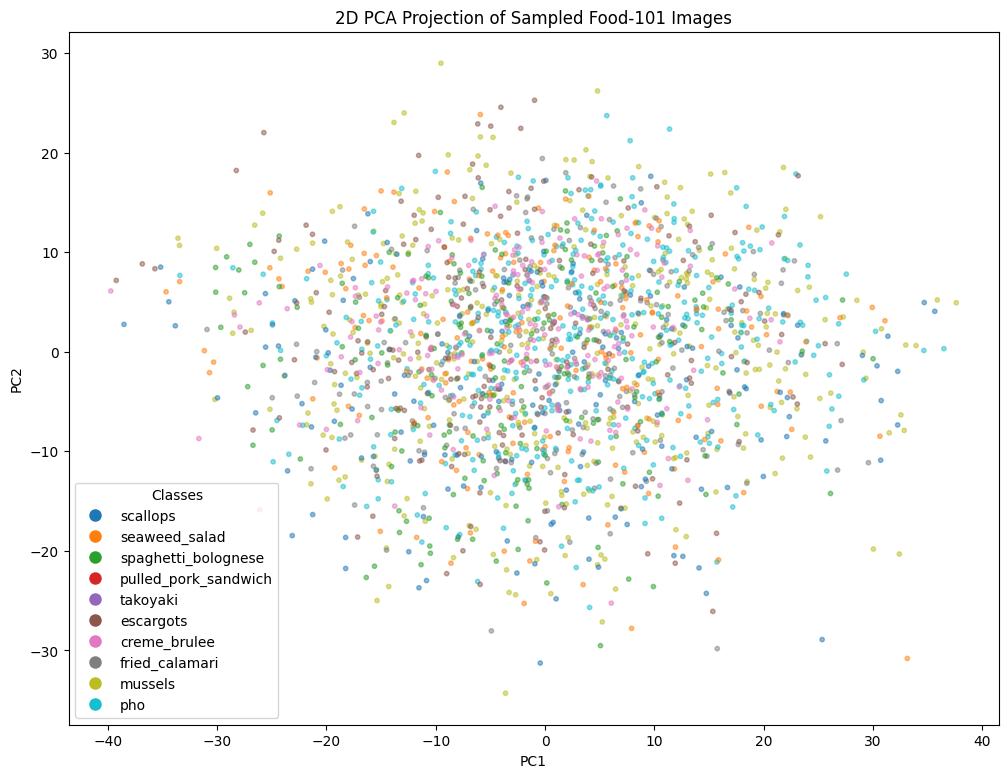

In [ ]:
num_classes_to_sample = 10#due to size of 101 we randomly sample 10 classes
classnames = train_dataset64.classes  # Food-101 class names
sampled_classes = random.sample(classnames, num_classes_to_sample)
print("Sampled Food-101 classes for PCA:", sampled_classes)


max_per_class = 200
class_indices = {cls: [] for cls in sampled_classes}

for idx, (_, label) in enumerate(train_dataset64):
    cls = classnames[label]
    if cls in sampled_classes and len(class_indices[cls]) < max_per_class:
        class_indices[cls].append(idx)

    # stop if all classes filled
    if all(len(class_indices[c]) >= max_per_class for c in sampled_classes):
        break

subset_indices = sum(class_indices.values(), [])
pca_subset = Subset(train_dataset64, subset_indices)

loader_pca = DataLoader(pca_subset, batch_size=len(pca_subset), shuffle=False)
images, labels = next(iter(loader_pca))
mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

images = images * std + mean
images = images.clamp(0,1)


X = images.reshape(images.shape[0], -1).numpy()
y = labels.numpy()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(12, 9))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=y, cmap="tab10",
    s=10, alpha=0.5
)

colors = plt.cm.tab10(np.linspace(0, 1, num_classes_to_sample))
handles = [
    plt.Line2D([], [], marker='o', color=colors[i],
               linestyle='', markersize=8)
    for i in range(num_classes_to_sample)
]

plt.legend(handles, sampled_classes, title="Classes", fontsize=10)
plt.title("2D PCA Projection of Sampled Food-101 Images")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


Although we've only sampled 200 images from 10 classes, this PCA plot already shows that Food101 has a more complex underlying structure than CIFAR-10.

As we can see, the projected points are widely and randomly scattered with no distinct clusters, showing high variability and overlap between classes.  

This is to be expected because PCA on raw pixel values captures mostly global colour and brightness differences, which isn't enough to seperte visually diverse categories, suggesting we have a lot of visual diversity on our dataset, which is more representative of a real-world scenario.

# Overview of our project
We aim to optimise and compare different model architectures that are acheivable despite our limitations, before testing their robustness on harder to interpret variations of the images.

This way we are able to accurately compare the computational performance. We focus on accuracy, loss and time as our metrics, however we note that time may also have other contributing factors.

In this methods section we will talk through optimisations on CIFAR-10, as this provided a quick and easy to work with toy dataset to see how changing various hyper parameters affected performance.

We then create ResNet18 from Scratch Using PyTorch and comparing to the plain model [4] using optimisations that we identified with the CIFAR-10 dataset. We adapt and reduce our food101 dataset in order to reduce training times.

We explore Variable Transformer models and train them on both the CIFAR-10 and Food101 datasets, seeing how these state of the art models are able to perform with a simple and a more complex dataset.

Finally, by evaluating robustness on transformed versions of the test data, we are able to see how succeptible to noise, change in lighting etc our models truly are.


# **Optimization using CIFAR-10**


We take and optimise code designing a CNN which classifies images from the CIFAR 10 dataset.

Original code: https://medium.com/data-bistrot/a-simple-image-classifier-with-a-python-neural-network-82a5522fe48b

4 files in the github repository are annotated and explained code updating the model repeatedly before reaching a final model. This is a more compact version.

We have imported the CIFAR-10 data in the 'About our dataset' section, so from here we can define a simple Neural Network.

**Define the neural network**

**Network architecture**

The first three lines:



```
class Net(nn.Module):
    def __init__(self):
        super().__init__()
```
define a CNN with 2 convolutional layers, 2 pooling layers and 3 fully connected layers.


**Overall layers structure:**

Input layers: image e.g 32x32x3

Convolutional layers: extracts feature from input dataset. applies kernels to input image(s). Kernels are generally smaller matrices e.g 3x3. Slides over input image data and computes dot product between kernel weight and the corresponding input image patch. Output of this layer is referred to as feature maps. Suppose we use 12 filters (kernels) for this layer - we would then get an output volume of dimension 32x32x12.

Activation layer: Adding an activation function to the output of the preceding layer adds nonlinearity to the network. e.g ReLU.

Pooling layer: periodically inserted in the CNN architecture (also called covnets). Main function is to reduce the size of the volume which speeds up the computation and prevents overfitting. Two common types of pooling layer are max pooling and average pooling. Max pool with 2x2 filters and stride 2 gives volume 16x16x12.

Flattening: Resulting feature maps are flattened into a one dimensional vector after the convolution and pooling layers so they can be passed into a completely linked layer for categorisation or regression.

Fully connected layers: takes input from previous lyer and computes the final classification or regression task.

Overall NN looks like this:

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define a convolutional neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

the Net class defines the CNN with 2 convolutional layers, 2 pooling layers and 3 FC layers



```
class Net(nn.Module):
    def __init__(self):
        super().__init__()
```
Class inherits from nn.Module, which is the 'base class' for all NN modules in PyTorch.

init method 'initialises' the network's layers


**Layers**

First convolutional layer (conv1) looks like:



```
self.conv1 = nn.Conv2d(3, 6, 5)
```

which means there are 3 input channels (RGB colour channels), 6 'filters' (feature maps /kernels), and 5x5 kernel size (so each filter will be 5x5 pixels)



```
self.pool = nn.MaxPool2d(2, 2)
```

defines a max pooling layer. Max pooling reduces the spatial dimensions of each feature map while retaining the most important information. By summarising information, max pooling makes the network more efficient and less prone to overfitting.



```
self.fc1 = nn.Linear(16 * 5 * 5, 120)
self.fc2 = nn.Linear(120, 84)
self.fc3 = nn.Linear(84, 10)
```

After the convolutional and pooling layers, the image has passed through multiple stages of feature extraction, where its original spatial dimensions are reduced significantly. This new image contains the 'essential features' identified by the network. Now the network transitions to FC layers. These take the flattened output from the conv stages and treat it as a single array of features (no longer in a spatial grid).

Now the FC layers try to map the learned features to specific classes - i.e here it would be to 'plane','dog' etc.

fc1 layer: has 400 input features (16x5x5) and 120 output features. high number of features allows network to start forming a higher level understanding of the image
fc2 layer: 120 features condensed to 84
fc3 layer: outputs 10 values, each representing a class in CIFAR-10 dataset. Each value corresponds to the likelihood of the image belonging to one of the 10 classes.



The above sets up the model, a loss function and an optimiser, so that we can train the network. Here's a further breakdown:


```
net = Net()
```
net creates an 'instance' our our neural network model Net. This model is like a "blank slate", as it has a learning framework set up but hasn't yet actually learnt from data.


```
criterion = nn.CrossEntropyLoss()
```
The above is the loss function. We use CrossEntropyLoss which is best for classification problems. The idea behind this function is to measure the difference between the models predictions and actual labels.



```
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
```
This sets up the 'optimiser', which updates weights and biases to reduce loss at each training step. Here we use stochastic gradient descent (SGD), which takes small steps in the direction that reduces the loss.

The learning rate (lr=0.001) controls step size. A small learning rate ensures gradual improvements, while momentum (momentum = 0.9) helps smooth out the updates, making the training more stable and efficient.




**NOTE: much more network architecture discussion in CNNv1.ipynb, here omitted for brevity**

**Training and saving the model**

In [ ]:
from tqdm import tqdm

EPOCHS = 2
print("Training...")
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch + 1} of {EPOCHS}", leave=True, ncols=80)):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Save our trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Training...


Epoch 2 of 2: 100%|████████████████████████| 5000/5000 [00:38<00:00, 130.40it/s]


after training, we save the model's state to a file

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

**Testing the model**

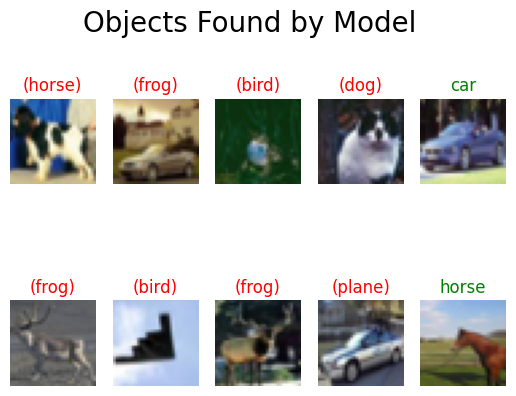

In [ ]:
# Pick random photos from training set
if dataiter == None:
    dataiter = iter(testloader)
images, labels = next(dataiter)

# Load our model
net = Net()
net.load_state_dict(torch.load(PATH))

# Analyze images
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Show results
for i in range(batch_size):
    # Add new subplot
    plt.subplot(2, int(batch_size/2), i + 1)
    # Plot the image
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    color = "green"
    label = classes[predicted[i]]
    if classes[labels[i]] != classes[predicted[i]]:
        color = "red"
        label = "(" + label + ")"
    plt.title(label, color=color)

plt.suptitle('Objects Found by Model', size=20)
plt.show()

**Evaluating model accuracy**

In [ ]:
# Measure accuracy for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy statistics
accuracies = []
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    accuracies.append(accuracy)
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

average_accuracy = sum(accuracies) / len(accuracies)
print(f'\nAverage accuracy over all classes: {average_accuracy:.1f} %') #we  add some code to measure overall accuracy as our baseline performance metric

Accuracy for class: plane is 65.3 %
Accuracy for class: car   is 55.4 %
Accuracy for class: bird  is 26.3 %
Accuracy for class: cat   is 15.8 %
Accuracy for class: deer  is 36.5 %
Accuracy for class: dog   is 57.9 %
Accuracy for class: frog  is 74.7 %
Accuracy for class: horse is 61.5 %
Accuracy for class: ship  is 58.1 %
Accuracy for class: truck is 55.1 %

Average accuracy over all classes: 50.7 %


So our baseline accuracy is 50%.

# **Version 2**

For our first changes we add batch normalisation, dropout regularisation and data augmentation, as is suggested by Rusiecki (2022). [2] Further explanation provided as we implement these below.

**Data Augmentation**

In the below cell we adapt the 'transform' function from the original code. Before, its purpose was just to transform the input to a PyTorch Tensor and normalise the values so that we could work with the data. Now, we use it for 'data augmentation' - randomly altering the images in various ways including rotations, cropping and colour changes. The idea is to force the model to learn significant features of the images, rather than overfitting to other features of the data. As an example of this, the pictures with the planes have a blue sky in the background. In the original, it's likely that the model partly classifies planes based on the specific shade and number of blue pixels in the image. However this could lead to problems, for example if the model was fed an image of a dog with a blue background. Altering the images forces the model to make classifications based on a *range* of features. When we alter the colour of the picture of the plane, the model can no longer rely on blue pixels to classify the plane. Therefore it has to base its decision based on a more varied set of features, and focus more on the key classification indicators. This should improve robustness and reduce overfitting. This means the new model should do a better job of classifying images *outside* of the training set. However, the initial training will be slower, since the augmented images are less thematic and it will be harder for the model to find similarities between equivalent labelled images.



In [ ]:
batch_size = 10
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),   #flips image with 50% probability
    transforms.RandomRotation(20),       #rotates image either +20 or -20 degrees
    transforms.RandomCrop(32, padding=3),#this adds 'padding' (adds a border of 3 black pixels to the image) and then selects a random 32x32 section
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # random color changes
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalising as before
])
transform_test = transforms.Compose([  #we keep the old transformations on the test set
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Now we have to split the data slightly differently:

In [ ]:
print("Downloading training data...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train) #we apply the new augmented transformation to the training set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

print("Downloading testing data...")
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test) #and apply a non-augmenting transform to the test set
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:02<00:00, 74.9MB/s]


In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
traindataiter = iter(trainloader)
images, labels = next(traindataiter)

We check that the images have been altered correctly:

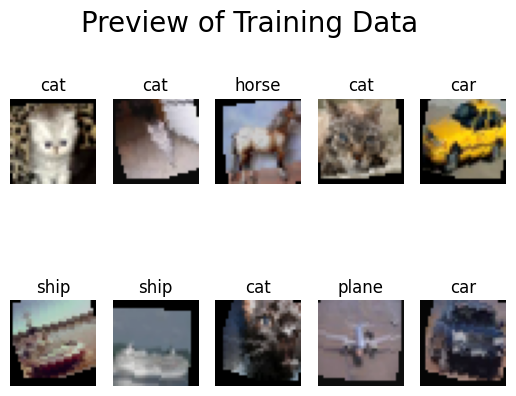

In [ ]:
for i in range(batch_size):
    plt.subplot(2, int(batch_size/2), i + 1) #creates subplots
    img = images[i] #extracts each image
    img = img / 2 + 0.5 #undoes normalisation to restore original colour range
    npimg = img.numpy() #convert tensor to numpy array so we can plot with matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #adjusts image dimensions
    plt.axis('off')
    plt.title(classes[labels[i]]) #labels subplots

plt.suptitle('Preview of Training Data', size=20)
plt.show()

**Updating the architecture: Adding Batch Normalisation and Dropout Regularisation**

In the new architecture, we have added batch normalisation. Batch normalisation is performed between convolution/FC layers and activation layers, but *not* after.

We use two different functions for batchnorm: BatchNorm1d and BatchNorm2d. They still perform the same task but they operate on different tensor shapes, since fully connected layers and convolution layers have different output shapes. Note that we don't apply batch normalisation after pooling layers or on the output, since that would just add noise.

We have *also* added dropout regularisation, but *only* to the fully connected layers, not the convolutional layers.

Generally, dropout isn't as useful in convolutional layers since most of the overfitting happens in fully connected layers (there are many more weights there - for example fc1 has 16x5x5x120=48000 while conv1 only has 3x6x5x5 = 450). Some CNNs use dropout in convolutional layers but many others don't. For example, ResNet doesn't.

Moreover, dropout would be especially harmful to this CNN because the feature maps are small. Dropping elements would leave the CNN with too little information and confuse the model. When we examined the training set images earlier, they are already low enough resolution that they are just recognisable. After pooling layers, even less information is left and so dropping elements would make the images near unrecognisable.

For brevity, we omit the code for this version of the architecture, since it's a straightforward modification (this is included in CNNv2.ipynb).

After running this model, we actually find that the average accuracy has *dropped* to 44.8%.

The accuracy over all classes has actually dropped from 50% to 45%. There's a couple of possible reasons for this, which we can tweak in subsequent models. Firstly, data augmentation could have slowed down the initial learning process as anticipated earlier. But we *have* increased the number of epochs accordingly so this shouldn't have caused such a massive performance drop. It might be worth reducing the noise slightly to improve initial learning. Another possible reason is the combination of batch normalisation and dropout regularisation. Since both of these normalise the data, it may end up overnormalised, which could also slow learning. The learning rate is also still quite low (lr=0.001), so it might be worth increasing this or trying a different optimiser that learns faster with less training.

# **Version 3**

In this document we work on version 2 to get rid of dropout, make data augmentation less noisy and increase learning rate.


**Data Augmentation**

We decrease the noisiness of the data augmentation to favour faster learning with less training. We do this by decreasing the parameters associated with rotation, cropping and colourjitter.

In [ ]:
batch_size = 10
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),   #flips image with 50% probability
    transforms.RandomRotation(10),       #rotates image either +10 or -10 degrees
    transforms.RandomCrop(32, padding=1),#now only pads 1 pixel
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1), # random color changes
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalising as before
])
transform_test = transforms.Compose([  #we keep the old transformations on the test set
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Again, the other changes are quite basic so there's not much need to review the code, though this is included in the CNNv3.ipynb file in the github repository.

The accuracy jumped up to 58.6%, so our changes helped. On the assumption that increased learning rate was one of the improvements, let's try changing the optimiser in the next draft.

# **Version 4 - Final version**

In this version we'll experiment with a different optimiser. Currently we're using SGD with a learning rate of 0.01, but there's a few potential problems with this. Firstly, the SGD learning rate requires tuning by trial and error, which is a time inefficient optimisation method. Secondly, SGD converges relatively slowly, especially with data augmentation and small batch sizes. We want to limit the runtime to just a few minutes while optimising performance, so we definitely want an optimiser that converges faster. A good choice for this is the Adam optimiser. The Adam (Adaptive Moment Estimation) optimiser uses RMSprop (root mean square propagation), which is a learning rate optimisation algorithm. RMSprop iteratively updates learning rate based on an exponentially weighted moving average of squared gradients. This should improve convergence rates, therefore improving the observed accuracy for a limited runtime.

Changing the optimiser is a very simple tweak - we just replace the SGD line with:

```
optimizer = optim.Adam(net.parameters(), lr=0.001)  # Replaced SGD with Adam
```
with the default parameter lr=0.001.


We also increase the number of epochs again, and track the training loss and test accuracy through each epoch to check that the learning rate doesn't plateau too early. This involves some relatively simple tweaks to a few code cells - see CNNv4.ipynb.

To avoid a long runtime we leave the code in the original file, and export the image of the graphs:

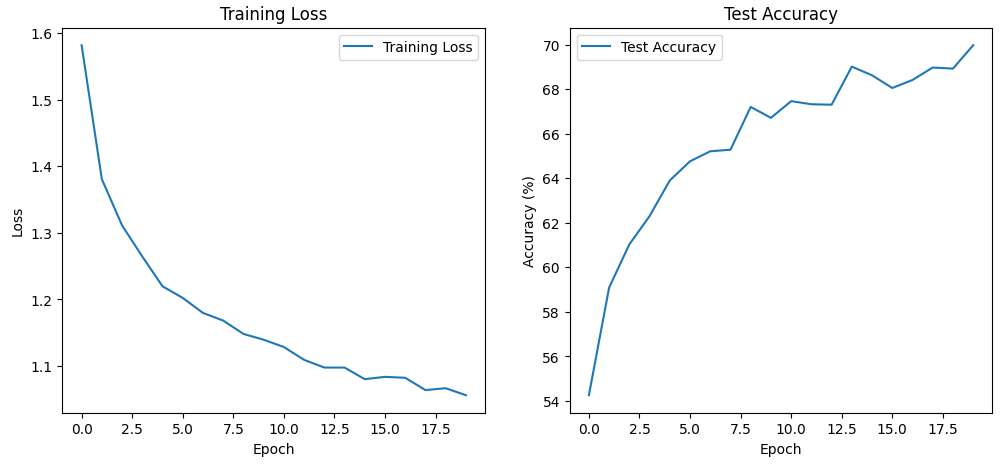

These graphs are promising, and indicate that learning steadily increased throughout the 20 epochs. It looks like the model reaches about 70% by the final epoch which is quite promising.

Testing the model gives a final average accuracy score of 64%, which is a sizeable increase from the initial 50%.

In a setting with access to greater computational power, the accuracy of this model could be greatly improved. With faster runtimes, could run more 'brute force' tuning experiments. As an example, this would mean that we find the ideal learning rate for an SGD optimiser, and then run it for a greater number of epochs so that it can converge.



Next we look closer at the effects of convolutional layers.



### Effect of Increasing Convolutional Layers on Performance
We compare basic CNNs with 1, 3, and 5 convolutional layers to see how depth affects performance on CIFAR-10. Each layer extracts features from the input, and stacking more layers lets the network capture more complex patterns. The training loop can be found in [Supplementary → Training loops → CNN depth analysis](https://github.com/K-Chorna02/DST_Assessment_2/blob/main/Report/Supplementary/training_loops/CNN_Depth_Analysis.py).


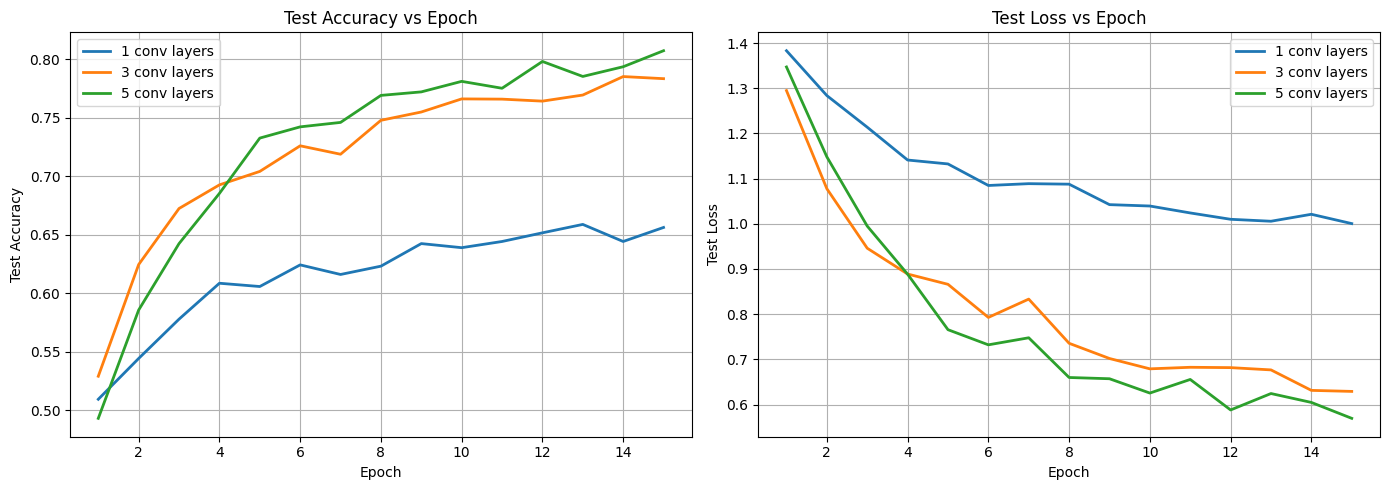

In [ ]:
# Raw GitHub CSV URLs
urls = {
    1: "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/results_graph/results_cnn_1layers.csv",
    3: "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/results_graph/results_cnn_3layers.csv",
    5: "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/results_graph/results_cnn_5layers.csv"
}

# Load CSVs
dfs = {layers: pd.read_csv(url) for layers, url in urls.items()}

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Test Accuracy
for layers, df in dfs.items():
    axes[0].plot(df['epoch'], df['test_acc'], label=f"{layers} conv layers", linewidth=2)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Test Accuracy")
axes[0].set_title("Test Accuracy vs Epoch")
axes[0].legend()
axes[0].grid(True)

# Test Loss
for layers, df in dfs.items():
    axes[1].plot(df['epoch'], df['test_loss'], label=f"{layers} conv layers", linewidth=2)
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Test Loss")
axes[1].set_title("Test Loss vs Epoch")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

We can see that models with more layers generally get higher test accuracy and lower test loss. Each convolutional layer applies a set of filters $F_i$ to the input feature maps $X_i$, producing $X_{i+1} = f(F_i * X_i + b_i)$, where $*$ is convolution and $f$ is a non-linear activation. Stacking layers lets the network build more complex representations step by step, so deeper networks can capture higher-level patterns in the data.

It’s also clear that adding more layers increases computation, since each layer adds extra operations. This means deeper networks take longer to train and evaluate, with training time roughly increasing as we add layers.

Overall, this shows that more convolutional layers generally improve accuracy and reduce loss. That’s why we go with an 18-layer CNN in this project, it balances training time with better performance and also makes it easier to compare with the shallowest pretrained ResNet models.

# Models

## About ResNet-18

After reading the paper 'Deep Residual learning for image recognition',[4] , we decided to focus on ResNet-18 architecture for image classification because it provides a strong balance between depth, performance, and computational efficiency. We start by training a plain convolutional network with 18 layers, then incorporate residual connections to form the full ResNet‑18. This allows us to study the impact of residual learning while keeping the network depth moderate.



We focus on ResNet‑18 as it is a moderately deep network, which is deep enough to extract meaningful hierarchical features but not so deep as to require excessive computation. By using 18 layers it makes it suitable for our project given time and GPU constraints.

## Applying ResNet18

## Baseline 18-layer CNN (Plain-18)

We first implement a baseline convolutional neural network with 18 layers without residual connections.



We use a plain 18 layer CNN as our baseline model for the CIFAR 10 dataset with ten classes. The network contains eight convolutional blocks followed by global average pooling and a fully connected layer. Each block consists of a convolutional layer, batch normalization, and a ReLU activation. This structure gives enough depth to learn meaningful hierarchical features while remaining simple and efficient to train on a small dataset like CIFAR 10.

All convolutional layers use 3×3 kernels. Small kernels capture local patterns effectively and, when stacked across many layers, create a large effective receptive field without adding unnecessary parameters. This helps the model learn fine textures, edges, and shapes that frequently appear in CIFAR 10 images. The number of channels increases from 64 in the early layers to 512 in the deeper layers so the network can represent more abstract features as depth increases.

Several convolutional layers use a stride of 2 to downsample the spatial resolution of the feature maps. This reduces the computational cost and encourages the network to compress visual information into channel depth. For stride 1 layers, we apply padding of 1 so the spatial dimensions remain unchanged.

Batch normalization follows each convolution to keep activation distributions stable and make optimisation more reliable. After batch normalization, a ReLU activation introduces non linearity so that the network can learn complex patterns rather than simple linear relationships.

After the final convolutional block, we apply global average pooling to collapse each feature map into a single value. This produces a compact representation and prevents the fully connected part of the network from becoming too large. The resulting 512 dimensional vector is then passed into a fully connected layer that outputs the ten class logits for CIFAR 10.

We train the network with mini batches rather than individual images. A batch size such as 32 or 64 provides stable gradient estimates and works well with batch normalization. This completes the baseline architecture we use for the CIFAR 10 classification task.

In [ ]:

#defining our plain18 network
class Plain18(nn.Module):
    def __init__(self, num_classes=101): #for Food-101
        super().__init__()

        # Each block = conv + batchnorm + ReLU
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # downsample
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # downsample
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # downsample
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer8 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)

        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"

We use a standard training setup with an optimizer, a loss function, a batch size, and a set number of epochs. These values are chosen because they work well given our memory and time limits. The idea is to have something that trains reliably without using too much GPU memory or taking too long. This gives us a good starting point, and of course, we could try other values or setups. We actually explored different options in more detail in the other section.

The training loop works the usual way. We pass the images through the network, compute the loss, backpropagate to get the gradients, and then update the model parameters. While training, we keep track of the loss and accuracy for both training and test sets, and we also record the time per epoch. Having all these metrics helps us see how well the model is learning and also gives an idea of efficiency, which is useful when thinking about scaling up experiments.

If we wanted to tune hyperparameters properly, we would set aside a validation set and test different choices like learning rate, batch size, or optimizer type. This would help us find a better configuration without touching the test set. Since hyperparameter tuning can take a lot of time, we didn’t do a full search here. But the other section explains the approaches we could use if we wanted to explore it more.

The training code for Plain-18 can be found in the [Report -> Supplementary -> Training code -> Plain-18 training](https://github.com/K-Chorna02/DST_Assessment_2/blob/main/Report/Supplementary/training_code/Plain18_training.py). We train the models and we save the weights that we use later to test for robustness. We create visualisations of the loss, accuracy and time for CIFAR-10.


The training loss drops very quickly and keeps decreasing until it becomes almost zero, which shows that the model learns the training data extremely well. At 50 epoch its already quite good and at 100 its even better. After this point the accuracy does still increase with loss decrasing but that imporovemtnt is essentially negligible. It odes seen unnessesarry to do 500 epoch for such dataset.  Training accuracy also reaches one hundred percent at around 100 epoch, so the network starts overfitting on the training set. The test loss, decreases at the start but then slowly rises again, even though the test accuracy keeps improving slightly over time. This again tells us that the model is starting to overfit, because it keeps getting better on the training set while the test loss stops improving. The best test accuracy is around ninety one percent, which happens much earlier than the point where the training metrics peak. The epoch time graph shows that training becomes stable after the initial setup, with later epochs taking roughly the same amount of time. Overall, the results show fast learning, and clear signs of overfitting once the network has trained for too long.


For moderate depths, such as our 18-layer baseline, adding layers generally improves performance because the network can learn more complex and abstract features. However, as networks become very deep, simply stacking more layers does not always help and can even make training harder. This is due to degradation, which occurs when gradients vanish or explode during backpropagation. When gradients vanish, early layers receive very small updates and learn very slowly, and when gradients explode, updates become unstable, which can cause training to fail. This shows that while deeper networks have more capacity, there are practical limits to how far we can increase depth without careful design or training strategies.

## Residual 18-layer CNN (ResNet-18)
We train the ResNet18 model using the same setup as the plain 18-layer CNN, but the architecture differs. We introduce residual blocks, where each block has two convolutional layers and a shortcut connection that allows the input to bypass the convolutions and be added to the output. This makes training more stable because the shortcut provides a direct path for gradients to flow backward. Even if gradients through the convolutional layers vanish or explode, the shortcut ensures that the gradient signal reaching earlier layers is preserved. This reduces the risk of training degradation and allows the network to take full advantage of the added depth, learning more complex features. The code is largely the same as before, but the network is now shorter and more efficient, as we use the same number of layers but incorporate residual connections.


We resize all the images to 64×64 pixels before training to make training faster and use less GPU memory. Smaller images need fewer calculations because the number of operations in convolution layers grows roughly with the height × width of the image. For example, reducing from 256×256 to 64×64 cuts the number of operations in the first layer by about 16×. This also produces smaller feature maps, so we can use a reasonable batch size without running out of memory. Overall, this keeps training time manageable, which is important because our GPU and time are limited. Although, we do lose some detail, 64×64 should be enough for the network to learn useful features in Food-101.

In [ ]:

# Residual Block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)   # residual connection
        out = F.relu(out)
        return out

# ResNet18 - residual
class ResNet18(nn.Module):
    def __init__(self, num_classes=101):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, planes, blocks, stride):
        layers = []
        layers.append(BasicBlock(self.in_planes, planes, stride))
        self.in_planes = planes * BasicBlock.expansion
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out,1)
        out = self.fc(out)
        return out



Again, the ResNet18 model was trained from scratch on Food101. All weights were randomly initialized, and the full network was optimized without using pretrained weights. The code for the training loop, can be found in [Report -> Supplementary -> training loops](https://github.com/K-Chorna02/DST_Assessment_2/blob/main/Report/Supplementary/training_loops/Resnet18_from_scratch_food101.py).


## Pretrained ResNet 18
Pre-trained models are neural networks that have already been trained on large datasets for a general task such as image classification. Using a pre-trained model allows us to leverage the features it has already learned, like edges, textures, and higher-level patterns, rather than training a network from scratch. This can save a lot of time and computational resources, and it often improves performance, especially when the dataset for the target task is smaller or limited.

However, pre-trained models are not always perfectly suited to every task. If the new dataset is very different from the dataset used for pre-training, the learned features may not fully capture the relevant patterns, which can limit performance. Additionally, large pre-trained networks can be computationally demanding and require significant memory, which may be a practical limitation depending on available hardware.

In this work, we focus on ResNet-18 as our pre-trained model. ResNet-18 is a residual network trained on ImageNet, a large dataset containing over a million images across 1,000 categories of everyday objects, animals, and scenes. The model has learned general visual features that can be applied to many tasks, including food classification. In this section, we explore how to adapt ResNet-18 for the Food-101 dataset using feature extraction and fine-tuning, two common approaches in transfer learning that allow the model to leverage its pre-trained knowledge while adapting to a new task.



### Feature extraction
For this experiment, we keep the same training setup and parameters as before, including batch size, epochs, loss, and optimizer. The main change is that we freeze all pre-trained ResNet-18 layers and only train the final fully connected layer, which is adjusted to output 101 classes for Food-101. This reduces the number of trainable parameters, making training faster and more stable, while still taking advantage of the rich feature representations learned from ImageNet. Using the same setup allows a direct comparison with our other models and demonstrates the benefits of transfer learning.

The training code for CIFAR-10 can be found [`Supplementary -> training_loops -> transfer_learning_resnet18`](https://github.com/K-Chorna02/DST_Assessment_2/blob/main/Report/Supplementary/training_loops/transfer_learning_resnet18.py).  

The training code for Food101 can be found [`Supplementary -> training_loops -> transfer_resnet18_food101`](https://github.com/K-Chorna02/DST_Assessment_2/blob/main/Report/Supplementary/training_loops/transfer_resnet18_food101.py).


### Fine tuning
Fine-tuning is another way to use a pre-trained model, such as ResNet-18 trained on ImageNet, where we allow more of its layers to be updated when training on a new dataset. Unlike feature extraction, where only the final classifier is trained, fine-tuning lets the network adjust its pre-trained weights to better fit the new data. This can improve performance, particularly when the target dataset differs from the one used for pre-training.

The lower layers of a convolutional network typically capture general features such as edges, textures, and shapes, which are broadly useful across tasks, while higher layers focus on patterns specific to the original task. By fine-tuning, we allow the weights in some or all layers to change, enabling the network to adapt to the new task. The trade-offs include increased computation, longer training times, and the need for a lower learning rate to prevent overwriting useful pre-trained weights too quickly.

For CIFAR-10, we perform partial fine-tuning by freezing the early layers of ResNet-18 specifically layer1 and layer2, which together contain 8 convolutional layers—and only updating the deeper layers (layer3 and layer4) and the final classifier. This approach allows the network to learn dataset-specific features while retaining general features learned from ImageNet. In this section, we explore partial fine-tuning on CIFAR-10 and compare it with feature extraction to see how adjusting pre-trained weights affects model performance.

## Vision Transformer
Vision Transformer (ViT) extend the Transformer architecture originally intrduced in 'Attention is all you need' (link) used in language processing to image recognition task. Instead of using convolutional kernels, ViT divides image into fixed-size patches, embeds each patch sa a token and process the resulting sequence using standard self-attention layers. Unlike, traditional CNN which captures global structure of an image using a kernel which is limited by the size of the kernel, ViT model patches division allow the model to captures the dependencies between pixel much further apart without over generalisation.

# Preliminary

Suppose we have an input image $x\in \mathbb{R}^{(H,W,C)}$, where H,W,C correspond to height, weight and channel (i.e. RGB) respectively. For each channel, ViT first divide the image within the channel into patches, then within each patch the image is flattened into a sequence of vectors containing the pixel values within their respective patches. This is denoted by
$$
P(X) = [x_1,...,x_N]
$$
where $x_i \in \mathbb{R}^{P^2C}$ is the flatten vector on the $i^{th}$ patch, P is patch size and $N =HW/P^2$ is the number of patches. Then, each patch is linearly project onto a space of hidden dimension in the transformer encoder. This process is called tokenization denote by

$$
T(x) = P(x)E_t
$$

where $E_t \in \mathbb{R}^{(P^2C) \times d}$ is the tokenization matrix with hidden dimension $d$. Then, the learnable class token is $x_{cls}\in\mathbb{R}^{d}$ is prepend to the vectors and the positional embeding $E_{pos} \in \mathbb{R}^{(N+1) \times d}$ is summed forming,

$$
z_0(x) = [x_{cls};T(x)] + E_{pos}.
$$
This token is then act as an input into the transformer encoder. In the original paper the ViT transformer encoder consist of alternating layer of multiheaded self-attension(MSA) and multi layer perceptron (MLP). Here MLP contains  small 2 layer neural network with each sub layer containing linear layer and (GELU) activation map. Between each layer of MSA and MLP a Layernorm(LN) is applied and residual is summed similar to Resnet architechture. This process is described below,

$$
z'_l = MSA(LN(z_{l-1})) + z_{l-1} \quad l=1,\dots,L,
$$
$$
z_l = MLP(LN(z'_l)) + z'_l \quad l = 1,\dots, L,
$$
$$
y = LN(z_L^0).
$$

Finally, we dicuss the self attention layer within MSA layer works by first introducing three learnable matrix called Query, Key, and Value denoted by $E_q, E_k, E_v$ where the dimension for $E_q$ and $E_k$ is $\mathbb{R}^{d \times d_s}$ while dimension for E_v is$. The attention score matrix $R \in \mathbb{R}^{((N+1)\times (N+1))}$ is then defined as:

$$
R(z) = zE_q(zE_k)^T.
$$

Here the diagonal entries for $R$ is represents self token relation while, off diagonal entries represent inter token relations. We then compute the output by dividing the $R$ with $d_s$ and put it through softmax function and the dot product between,

$$
SA(z) = softmax(\frac{R(z)}{\sqrt{d_s}})xE_v
$$

The MSA layer is simply multiple SA layer inparallel where we contatinates the SA layer and linearly projecting it. The full detail is given in the original paper



## ViT for small data set

It has been shown that Vision Transformers often struggle on small datasets because they lack the locality inductive bias that CNNs naturally possess. Convolutional networks typically begin with small, overlapping receptive fields that encode local textures and gradually expand to capture global structure. ViT, on the other hands, start with a receptive field equivalent to a non overlapping kernel with size equal to patch size (16x16 in original paper). This is relatively large compares to the early layer kenel size in Resnet architechtures. Consequently, this means that ViT is less able to capture relationship between closer pixels and therefore must learn locality information entirely from the data, which explains the underperformance for small dataset.

## LSA & SPT

In order to tackle these limitation on small datasets, we implimented the augmentation for ViT specifically designed for small dataset introduced in (link). The first augmentation we use is Shifted Patch Tokenization(SPT). This augmentation is done by first shifting the image by half a patch size, in 4 direction (up,down,left,right) then concatenated it back to the original image as new channels. This result in $C_{shifted} = C_{original} \times 5$, this modified tokenizasion is labeled as

$$
S(x) = LN(P([x,s_1,s_2,s_3,s_4]))E_S
$$

with $s_i \in \mathbb{R}^{(H\times W\times C)}$ is the shifted image and $E_S \in \mathbb{R}^{(P^2(5C)\times d}$ is the new linear projection with $d$ being the hidden dimension. this is implimented in our code as:

In [ ]:
class SPT(nn.Module):
    def __init__(self, *, dim, patch_size, channels = 3):
        super().__init__()
        patch_dim = patch_size * patch_size * 5 * channels

        self.to_patch_tokens = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim)
        )

    def forward(self, x):
        shifts = ((1, -1, 0, 0), (-1, 1, 0, 0), (0, 0, 1, -1), (0, 0, -1, 1))
        shifted_x = list(map(lambda shift: F.pad(x, shift), shifts))
        x_with_shifts = torch.cat((x, *shifted_x), dim = 1)
        return self.to_patch_tokens(x_with_shifts)

Another augmentation we have adopted is the Locality-self attention(LSA) adjustment of the self attention head. This is done by modifying the self-attention matrix $R$ by making the diagonal entry orresponding to the self token relation to negative infinity,

$$ R^{M}_{i,j}(x) =
\begin{cases}
R_{i,j}(x), & \text{if } i \neq j, \\
-\infty, & \text{if } i = j.
\end{cases}
$$

This encourage the model to emphasize inter relation token instead through soft max function. Additionally, the output for the self attention is modified so that $R$ is now divided by a learnable parameter $\tau$ instead of dimension $d_s$. This have been shown to sharpen the distribution of the self-attension matrix and therefore make the attension matrix more discriminative of unimportant tokens. and so the LSA is defined by,

$$
L(z) = softmax(\frac{R^M(z)}{\tau}zE_v)
$$

In [ ]:
class LSA(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.temperature = nn.Parameter(torch.log(torch.tensor(dim_head ** -0.5)))

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.temperature.exp()

        mask = torch.eye(dots.shape[-1], device = dots.device, dtype = torch.bool)
        mask_value = -torch.finfo(dots.dtype).max
        dots = dots.masked_fill(mask, mask_value)

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

Most of the implimentation is heavily based on (https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit_for_small_dataset.py)

# Training Performance Comparison

In this section we compares the training performance for all models both training from scratch and transfer learning. Because the aim is the compare the performance between different architure we have kept most hyper parameter consistent and augmentation the same throughout. For transfer learning, all model were pretrained on ImageNet 1k. Fine tuning is done by freezing only the first two layers of ResNet18 architure available in Pytorch. The feature extraction for ViT is done using ViT b16 model instead of SL-ViT as to the best of our knowledge there is no pretrained SL-ViT architecture available.

## CIFAR-10 Training from Scratch
| Parameter             | Plain18                  | ResNet18                 | SL-ViT (32x32 CIFAR-10) |
|-----------------------|-------------------------|-------------------------|-------------------------|
| Image Size            | 32x32                   | 32x32                   | 32x32                   |
| Train Transformations | Random horizontal flip, ToTensor, Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) | Random horizontal flip, ToTensor, Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) | Random horizontal flip, ToTensor, Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) |
| Test Transformations  | ToTensor, Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) | ToTensor, Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) | ToTensor, Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) |
| Batch Size            | 64                      | 64                      | 64                      |
| Model                 | Plain18 (18-layer CNN)  | ResNet18                | ViT (patch=4, dim=256, depth=6, heads=8, mlp_dim=512) |
| Epochs                | 500                     | 500                     | 500                     |
| Loss Function         | CrossEntropyLoss        | CrossEntropyLoss        | CrossEntropyLoss        |
| Optimizer             | AdamW (lr=1e-3, weight_decay=1e-2) | AdamW (lr=1e-3, weight_decay=1e-2) | AdamW (lr=1e-3, weight_decay=1e-2) |
| Scheduler             | CosineAnnealingLR (T_max=500, eta_min=1e-6) | CosineAnnealingLR (T_max=500, eta_min=1e-6) | CosineAnnealingLR (T_max=500, eta_min=1e-6) |
| Device                | RTX 3070TI Laptop        | RTX 3070TI Laptop        | RTX 3070TI Laptop        |




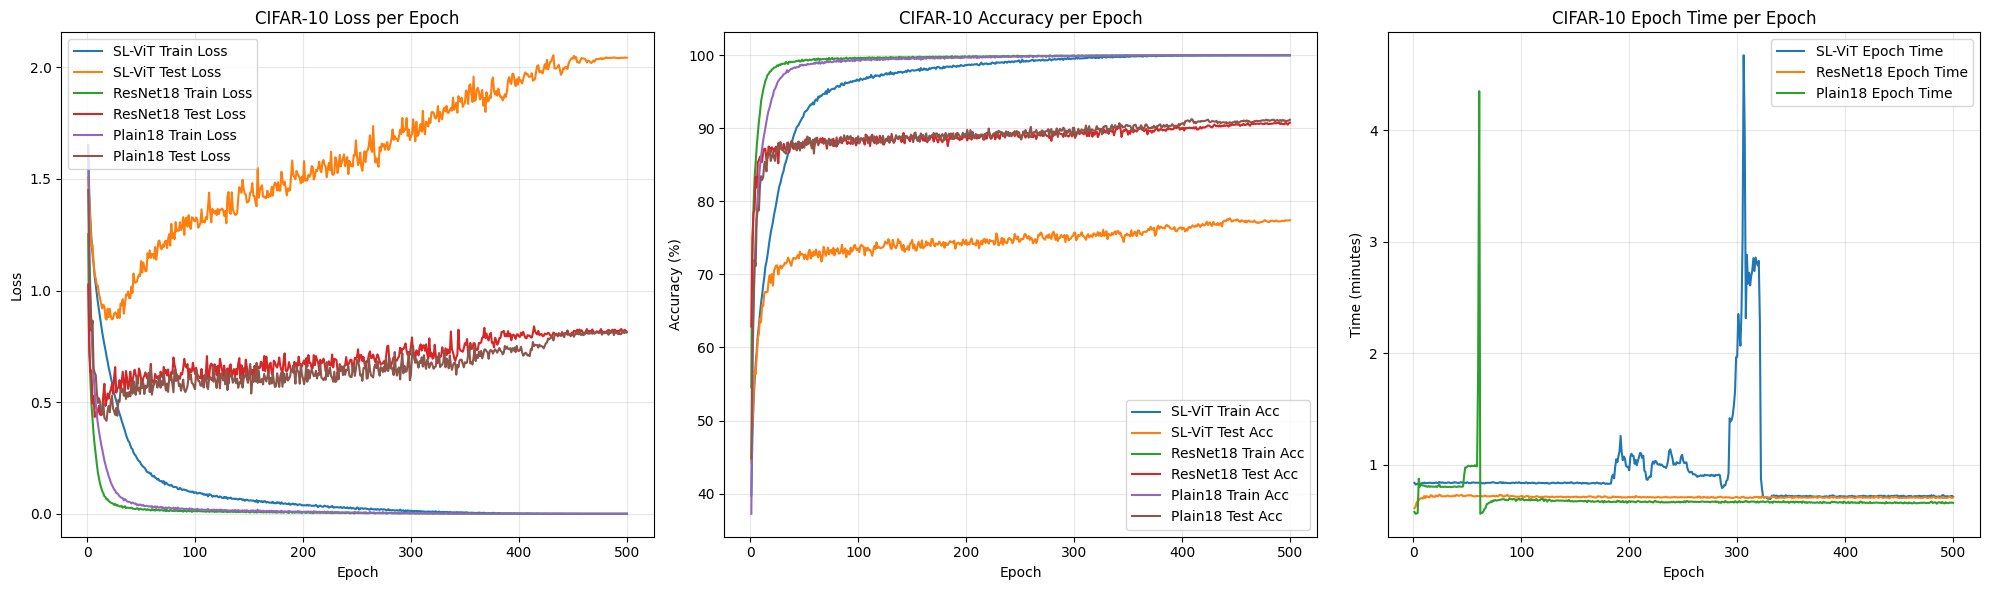

In [ ]:
url_vit = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/results_graph/slvit_cifar10_metrics.csv"
df_vit = pd.read_csv(url_vit)

epoch_vit = df_vit["epoch"]
train_loss_vit = df_vit["train_loss"]
test_loss_vit = df_vit["test_loss"]
train_acc_vit = df_vit["train_acc"] * 100
test_acc_vit = df_vit["test_acc"] * 100
epoch_time_vit = df_vit["epoch_time"] / 60

url_resnet = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/results_graph/resnet18_cifar10_metrics.csv"
df_res = pd.read_csv(url_resnet)

epoch_res = df_res["epoch"]
train_loss_res = df_res["train_loss"]
test_loss_res = df_res["test_loss"]
train_acc_res = df_res["train_acc"] * 100
test_acc_res = df_res["test_acc"] * 100
epoch_time_res = df_res["epoch_time"] / 60

url_plain18 = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/results_graph/plain18_cifar10_metrics.csv"
df_plain = pd.read_csv(url_plain18)

epoch_plain = df_plain["epoch"]
train_loss_plain = df_plain["train_loss"]
test_loss_plain = df_plain["test_loss"]
train_acc_plain = df_plain["train_acc"] * 100
test_acc_plain = df_plain["test_acc"] * 100
epoch_time_plain = df_plain["epoch_time"] / 60

plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.plot(epoch_vit, train_loss_vit, label="SL-ViT Train Loss")
plt.plot(epoch_vit, test_loss_vit, label="SL-ViT Test Loss")
plt.plot(epoch_res, train_loss_res, label="ResNet18 Train Loss")
plt.plot(epoch_res, test_loss_res, label="ResNet18 Test Loss")
plt.plot(epoch_plain, train_loss_plain, label="Plain18 Train Loss")
plt.plot(epoch_plain, test_loss_plain, label="Plain18 Test Loss")
plt.title("CIFAR-10 Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epoch_vit, train_acc_vit, label="SL-ViT Train Acc")
plt.plot(epoch_vit, test_acc_vit, label="SL-ViT Test Acc")
plt.plot(epoch_res, train_acc_res, label="ResNet18 Train Acc")
plt.plot(epoch_res, test_acc_res, label="ResNet18 Test Acc")
plt.plot(epoch_plain, train_acc_plain, label="Plain18 Train Acc")
plt.plot(epoch_plain, test_acc_plain, label="Plain18 Test Acc")
plt.title("CIFAR-10 Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epoch_vit, epoch_time_vit, label="SL-ViT Epoch Time")
plt.plot(epoch_res, epoch_time_res, label="ResNet18 Epoch Time")
plt.plot(epoch_plain, epoch_time_plain, label="Plain18 Epoch Time")
plt.title("CIFAR-10 Epoch Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (minutes)")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


The graph compare the training dynamic between ViT, Resnet18, Plain18 architecture trained from scratch on CIFAR-10 dataset across 500 epochs. From the graph we observed t hat Plain 18 and Resnet18 exhibit near identical behaviour with Plain 18 slightly edging out in terms of performance in accuracy and test loss. From the loss curve (top left panel), all model show rapid decrease in training loss, but Resnet and Plain18 converges much faster while ViT decreases more slowly and continue to reduce training loss over 100 of epochs. On the other hand the test lost plot shows a sharp contrast. Resnet and Plain 18 test loss stabalise at a relatively low value with mild fluctaution while ViT's test loss steadily increases throughout training, suggesting that it may be more prone to overfitting.

The accuracy curves(top right panel) shows that Resnet 18 and Plain 18 achieves a strong, stable test accuracy at around 89-91% which is much high than ViT test accuracy which hover at around75-80% even after 500 epoch.

Overall, the comparison demonstrate that Resnet 18 generalise better on CIFAR-10, while the non-pretrained ViT struggeles potentially due to its weaker inductive bias despite the SPT and LSA augmentation.

## CIFAR-10 Feature Extraction and Fine Tuning

| Parameter                | ResNet18 Fine-Tune               | ResNet18 Feature Extraction       | ViT-B/16 Feature Extraction       |
|--------------------------|---------------------------------|---------------------------------|---------------------------------|
| Dataset                  | CIFAR-10 (10 classes)            | CIFAR-10 (10 classes)            | CIFAR-10 (10 classes)            |
| Image Size               | 224x224                          | 224x224                          | 224x224                          |
| Train Transformations    | RandomHorizontalFlip + Preprocess | RandomHorizontalFlip + Preprocess | RandomHorizontalFlip + Preprocess |
| Test Transformations     | Preprocess                        | Preprocess                        | Preprocess                        |
| Batch Size               | 64                                | 64                               | 64                               |
| Model                    | ResNet18 pretrained on ImageNet | ResNet18 pretrained on ImageNet | ViT-B/16 pretrained on ImageNet |
| Classifier Replacement   | fc → Linear(512,10)              | fc → Linear(512,10)              | heads → Linear(768,128) + ReLU + Linear(128,10) |
| Freeze Backbone?         | Layer1 & Layer2 frozen           | Freeze all except fc             | Freeze all except heads           |
| Loss Function            | CrossEntropyLoss                 | CrossEntropyLoss                 | CrossEntropyLoss                 |
| Optimizer                | AdamW (lr=1e-3, weight_decay=1e-2) | AdamW (lr=1e-3, weight_decay=1e-2) | AdamW (lr=1e-3, weight_decay=1e-2) |
| Scheduler                | CosineAnnealingLR (T_max=epochs, eta_min=1e-6) | CosineAnnealingLR (T_max=epochs, eta_min=1e-6) | CosineAnnealingLR (T_max=epochs, eta_min=1e-6) |
| Epochs                   | 30                              | 30                               | 30                               |
| Metrics Saved            | Train/Test loss & acc, epoch time | Train/Test loss & acc, lr, epoch time | Train/Test loss & acc, lr, epoch time |
| Device                   | RTX 3070TI Laptop                 | RTX 3070TI Laptop                 | RTX 3070TI Laptop                 |
| Notes                    | Fine-tune Layer3+fc only          | Feature extraction (freeze backbone) | Feature extraction (freeze backbone) |



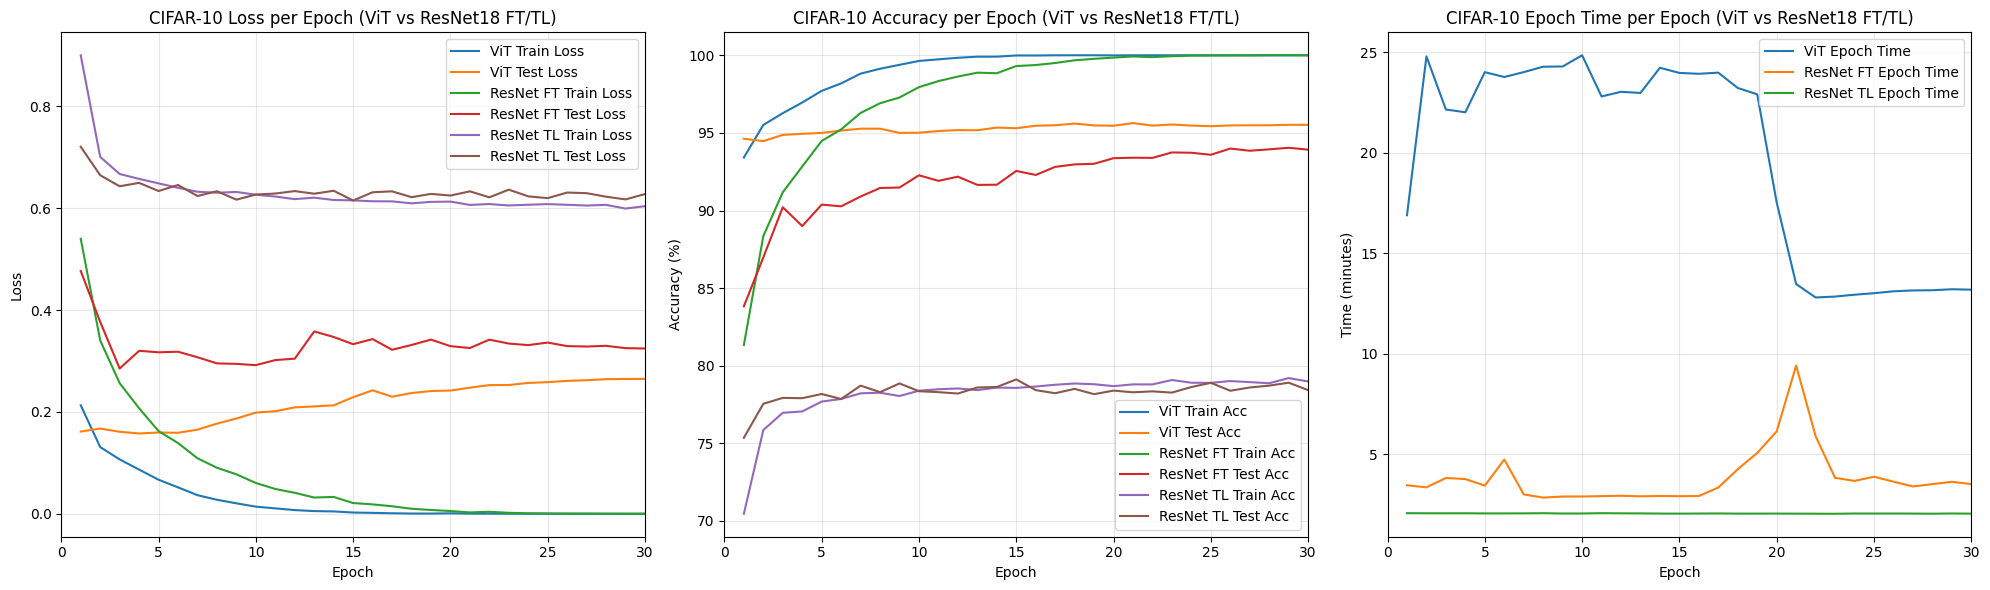

In [ ]:
url_vit = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/results_graph/vit_b16_cifar10_transfer_metrics.csv"
df_vit = pd.read_csv(url_vit)

epoch_vit = df_vit["epoch"]
train_loss_vit = df_vit["train_loss"]
test_loss_vit = df_vit["test_loss"]
train_acc_vit = df_vit["train_acc"] * 100
test_acc_vit = df_vit["test_acc"] * 100
lr_vit = df_vit["lr"]
epoch_time_vit = df_vit["epoch_time"] / 60

url_res_ft = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/results_graph/resnet18_finetune_cifar10_metrics.csv"
df_res_ft = pd.read_csv(url_res_ft)

epoch_res_ft = df_res_ft["epoch"]
train_loss_res_ft = df_res_ft["train_loss"]
test_loss_res_ft = df_res_ft["test_loss"]
train_acc_res_ft = df_res_ft["train_acc"] * 100
test_acc_res_ft = df_res_ft["test_acc"] * 100
epoch_time_res_ft = df_res_ft["epoch_time"] / 60

url_res_tl = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/results_graph/resnet18_cifar10_transfer_metrics.csv"
df_res_tl = pd.read_csv(url_res_tl)

epoch_res_tl = df_res_tl["epoch"]
train_loss_res_tl = df_res_tl["train_loss"]
test_loss_res_tl = df_res_tl["test_loss"]
train_acc_res_tl = df_res_tl["train_acc"] * 100
test_acc_res_tl = df_res_tl["test_acc"] * 100
epoch_time_res_tl = df_res_tl["epoch_time"] / 60

plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.plot(epoch_vit, train_loss_vit, label="ViT Train Loss")
plt.plot(epoch_vit, test_loss_vit, label="ViT Test Loss")
plt.plot(epoch_res_ft, train_loss_res_ft, label="ResNet FT Train Loss")
plt.plot(epoch_res_ft, test_loss_res_ft, label="ResNet FT Test Loss")
plt.plot(epoch_res_tl, train_loss_res_tl, label="ResNet TL Train Loss")
plt.plot(epoch_res_tl, test_loss_res_tl, label="ResNet TL Test Loss")
plt.title("CIFAR-10 Loss per Epoch (ViT vs ResNet18 FT/TL)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xlim(0, 30)
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epoch_vit, train_acc_vit, label="ViT Train Acc")
plt.plot(epoch_vit, test_acc_vit, label="ViT Test Acc")
plt.plot(epoch_res_ft, train_acc_res_ft, label="ResNet FT Train Acc")
plt.plot(epoch_res_ft, test_acc_res_ft, label="ResNet FT Test Acc")
plt.plot(epoch_res_tl, train_acc_res_tl, label="ResNet TL Train Acc")
plt.plot(epoch_res_tl, test_acc_res_tl, label="ResNet TL Test Acc")
plt.title("CIFAR-10 Accuracy per Epoch (ViT vs ResNet18 FT/TL)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.xlim(0, 30)
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epoch_vit, epoch_time_vit, label="ViT Epoch Time")
plt.plot(epoch_res_ft, epoch_time_res_ft, label="ResNet FT Epoch Time")
plt.plot(epoch_res_tl, epoch_time_res_tl, label="ResNet TL Epoch Time")
plt.title("CIFAR-10 Epoch Time per Epoch (ViT vs ResNet18 FT/TL)")
plt.xlabel("Epoch")
plt.ylabel("Time (minutes)")
plt.xlim(0, 30)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()





The result show that on CIFAR-10, the ViT achieves the strongest overall performance whem we use feature extraction with test accuracy succeeding 95% with steady low test lost, indicating overfitting despite strong end-to-end performance. On the other hand, Resnet 18 fine-tuning show gradual increase on accuracy with stable test lost, This indicates that it can benefit significantly from more epoch. Potentially, it may out perform the ViT in terms of accuracy. Finally, Resnet18 feature extraction perform substantially wrose both in terms of test loss and accuracy. This reflects the limited suitability of frozen convolutional feature for low-resolution images. Training-time comparisons show that ViT is required significantly more time per epoch. This is likely due to the different way in which ViT and Resnet architecture process the information of a 224x224 upscaled image.  

Overall, ViT shows great generalization on CIFAR-10 when transfer learnring is used. The improve in performance per epoch is significantly less than Resnet model, and given more epochs, Resnet18 fine tuning model may out perform ViT.

## Food-101 Training from Scratch

| Parameter                | SL-ViT Food101                     | ResNet18 Food101                  |
|--------------------------|----------------------------------|----------------------------------|
| Dataset                  | Food101 (101 classes)             | Food101 (101 classes)             |
| Image Size               | 64x64                             | 64x64                             |
| Train Transformations    | Resize, RandomHorizontalFlip, ToTensor, Normalize | Resize, RandomHorizontalFlip, ToTensor, Normalize |
| Test Transformations     | Resize, ToTensor, Normalize       | Resize, ToTensor, Normalize       |
| Batch Size               | 64                                | 64                                |
| Model                    | SL-ViT (dim=256, depth=6, heads=8, mlp_dim=512) | ResNet18 custom                     |
| Classifier Replacement   | ViT heads → Linear(256,101)       | ResNet18 fc → Linear(num_features,101) |
| Freeze Backbone?         | None (train all)                  | None (train all)                  |
| Loss Function            | CrossEntropyLoss                  | CrossEntropyLoss                  |
| Optimizer                | AdamW (lr=1e-4, weight_decay=1e-2) | AdamW (lr=1e-3, weight_decay=1e-2) |
| Scheduler                | CosineAnnealingLR (T_max=epochs, eta_min=1e-6) | CosineAnnealingLR (T_max=epochs, eta_min=1e-6) |
| Epochs                   | 100                               | 100                               |
| Metrics Saved            | Train/Test loss & acc, lr, epoch time | Train/Test loss & acc, lr, epoch time |
| Device                   | RTX 3070TI Laptop                        | RTX 3070TI Laptop                         |
| Notes                    | Vision Transformer, 8×8 patches, emb_dropout=0.1, dropout=0.1 | Standard ResNet18, simple feature extractor, train from scratch on Food101 |



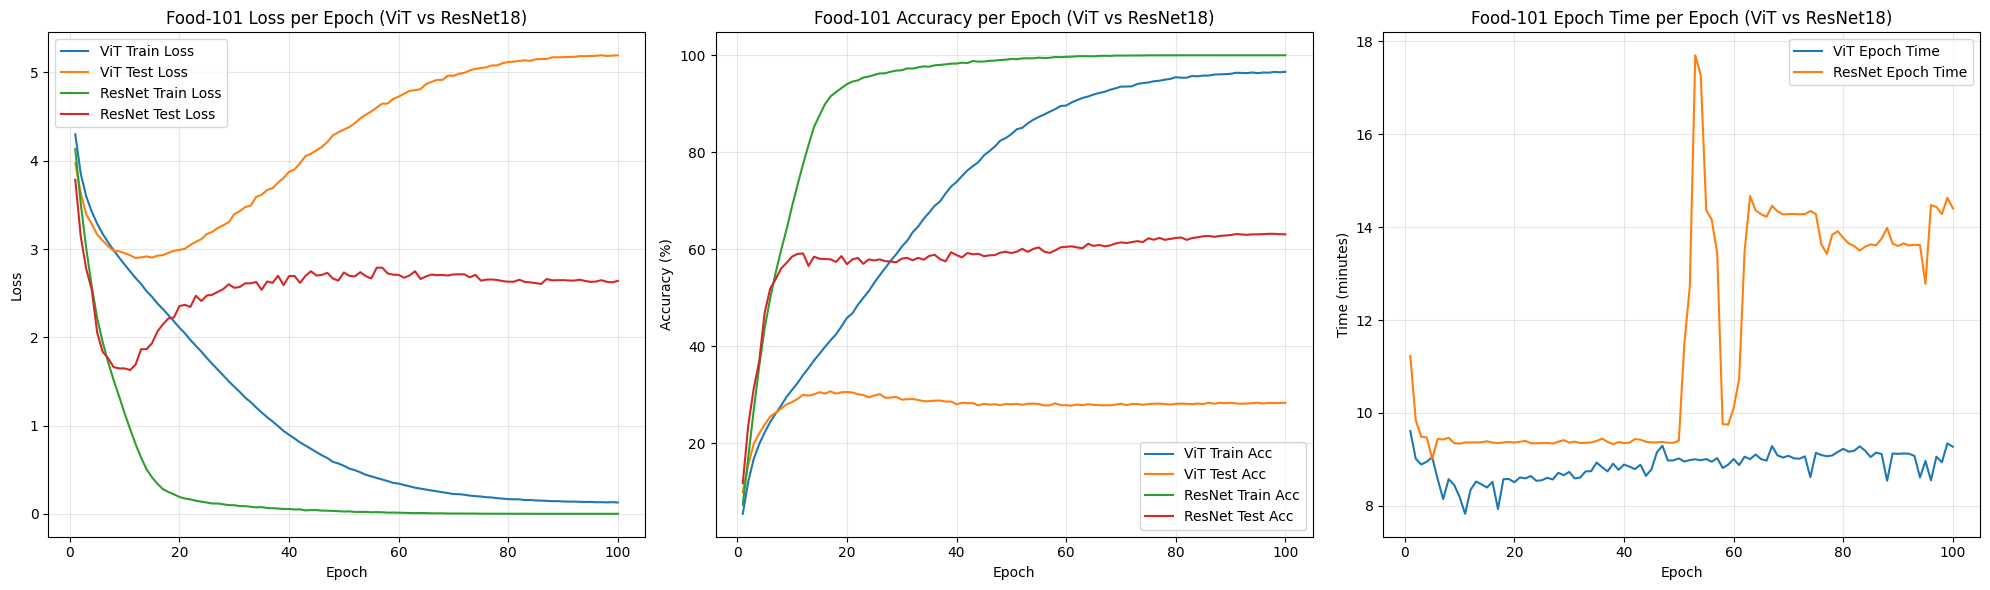

In [ ]:
url_vit = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/results_graph/slvit_food101_metrics.csv"
df_vit = pd.read_csv(url_vit)

epoch_vit = df_vit["epoch"]
train_loss_vit = df_vit["train_loss"]
test_loss_vit = df_vit["test_loss"]
train_acc_vit = df_vit["train_acc"] * 100
test_acc_vit = df_vit["test_acc"] * 100
epoch_time_vit = df_vit["epoch_time"] / 60

url_resnet = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/results_graph/resnet18_food101_metrics.csv"
df_res = pd.read_csv(url_resnet)

epoch_res = df_res["epoch"]
train_loss_res = df_res["train_loss"]
test_loss_res = df_res["test_loss"]
train_acc_res = df_res["train_acc"] * 100
test_acc_res = df_res["test_acc"] * 100
epoch_time_res = df_res["epoch_time"] / 60

plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
plt.plot(epoch_vit, train_loss_vit, label="ViT Train Loss")
plt.plot(epoch_vit, test_loss_vit, label="ViT Test Loss")
plt.plot(epoch_res, train_loss_res, label="ResNet Train Loss")
plt.plot(epoch_res, test_loss_res, label="ResNet Test Loss")
plt.title("Food-101 Loss per Epoch (ViT vs ResNet18)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1,3,2)
plt.plot(epoch_vit, train_acc_vit, label="ViT Train Acc")
plt.plot(epoch_vit, test_acc_vit, label="ViT Test Acc")
plt.plot(epoch_res, train_acc_res, label="ResNet Train Acc")
plt.plot(epoch_res, test_acc_res, label="ResNet Test Acc")
plt.title("Food-101 Accuracy per Epoch (ViT vs ResNet18)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1,3,3)
plt.plot(epoch_vit, epoch_time_vit, label="ViT Epoch Time")
plt.plot(epoch_res, epoch_time_res, label="ResNet Epoch Time")
plt.title("Food-101 Epoch Time per Epoch (ViT vs ResNet18)")
plt.xlabel("Epoch")
plt.ylabel("Time (minutes)")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


The result shows that when trained from scratch on Food-101, Resnet18 and VitT show distinctly differently behaviour. ResNet18 converges relatively quickly driving training loss close to zero at around 20 epochs yet its test loss remains high and test accuracy plateaus around 60%. This seems to suggest that it begins to overfit. ViT, in contrast, learns significantly slower than ResNet18  while only achieving test accuracy of only 30%. These patterns is similar to that of CIFAR-10 where test loss is minimise at earlier epoch while ViT has consistently lower accuracy than resnet when training from scratch even with augmentation. This strongly suggest hat ResNet can utilize smaller data than that of ViT which is in agreement with the literature where ViT has the need to learn local inductive bias entirely from the dataset, which means it require more data to perform well.

## Food-101 feature extraction

**CHANGE THIS VIT IS INCORRECT**  


| Parameter                | ResNet18 Food101 (Frozen Backbone)                            | ViT-B/16 Food101 (Frozen Backbone)                                   |
|--------------------------|---------------------------------------------------------------|------------------------------------------------------------------------|
| Dataset                  | Food101 (101 classes)                                         | Food101 (101 classes)                                                 |
| Image Size               | 224x224                                                       | 224x224                                                               |
| Train Transformations    | Resize 256→224 crop, RandomHorizontalFlip, RandomRotation, RandomAffine, ColorJitter, RandomGrayscale, ToTensor, Normalize | Resize 256→224 crop, RandomHorizontalFlip, RandomRotation, RandomAffine, ColorJitter, RandomGrayscale, ToTensor, Normalize |
| Test/Val Transformations | Resize 256→224 crop, ToTensor, Normalize                     | Resize 256→224 center crop, ToTensor, Normalize                       |
| Batch Size               | 128                                                           | 128                                                                   |
| Model                    | ResNet18 pretrained on ImageNet (IMAGENET1K_V1)              | ViT-B/16 pretrained on ImageNet (ViT_B_16_Weights.IMAGENET1K_V1)      |
| Classifier Replacement   | fc → Dropout(0.3) + Linear(num_features, 101)                | heads → Linear(768, 128) → ReLU → Linear(128, 101)                    |
| Freeze Backbone?         | All except layer4 and fc                                      | All pretrained ViT parameters frozen; only new MLP head is trainable  |
| Loss Function            | CrossEntropyLoss                                              | CrossEntropyLoss                                                      |
| Optimizer                | Adam (lr = 1e-3, weight_decay = 1e-3)                        | Adam (lr = 1e-3, weight_decay = 1e-3)                                 |
| Scheduler                | StepLR (step_size = 5, gamma = 0.2)                          | StepLR (step_size = 5, gamma = 0.2)                                   |
| Epochs                   | 30                                                            | 30                                                                    |
| Metrics Saved            | Train/Val loss & acc, lr, epoch time                         | Train/Val loss & acc, lr, epoch time                                  |
| Device                   |RTX 3070TI Laptop                                                     | COLAB A100 GPU                                                             |




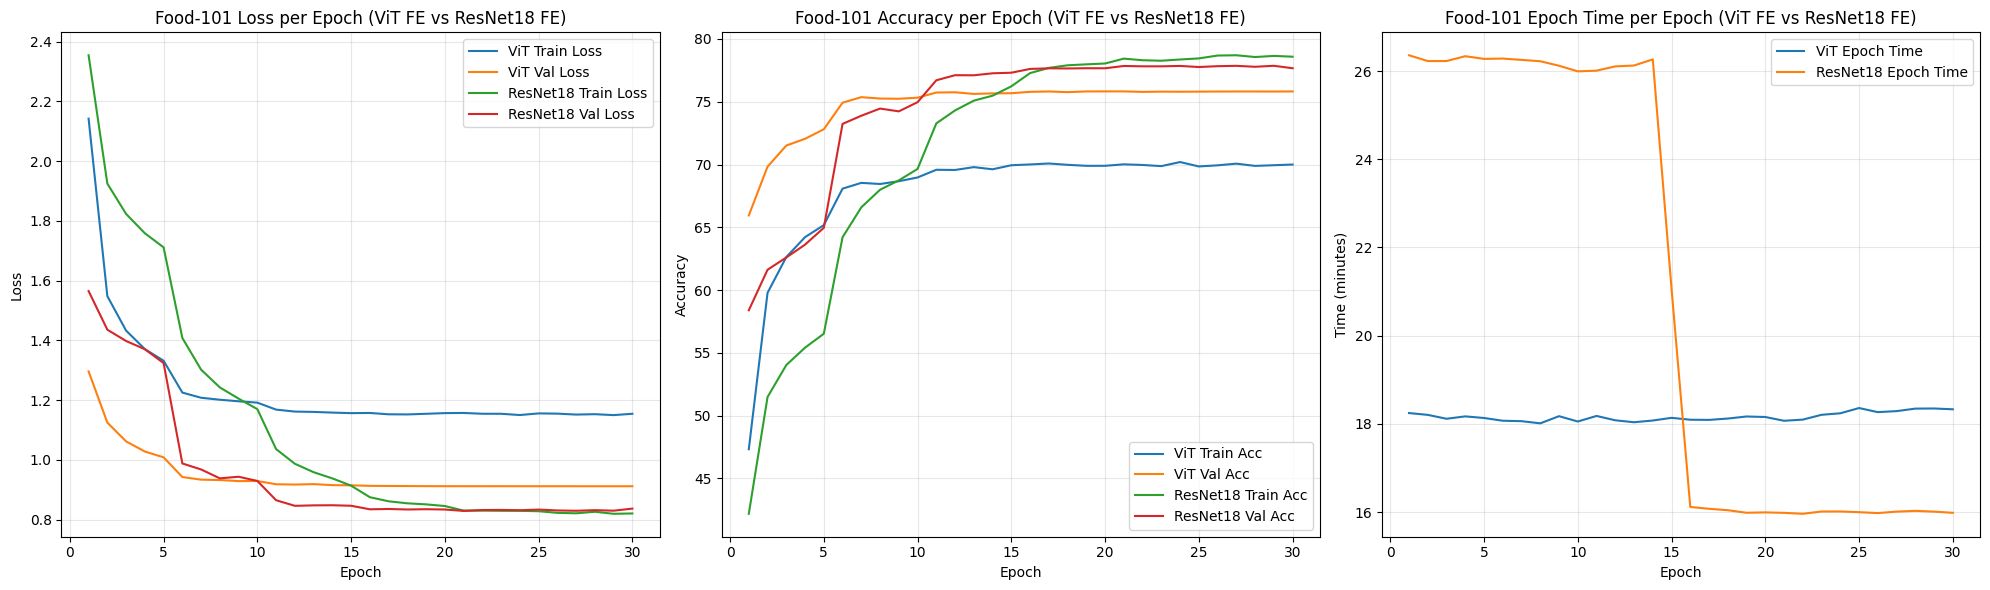

In [ ]:
url_vit = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/results_graph/vit_log.csv"
df_vit = pd.read_csv(url_vit)

epoch_vit = df_vit["epoch"]
train_loss_vit = df_vit["train_loss"]
val_loss_vit = df_vit["val_loss"]
train_acc_vit = df_vit["train_acc"]
val_acc_vit = df_vit["val_acc"]
lr_vit = df_vit["lr"]
epoch_time_vit = df_vit["epoch_time"]

url_resnet = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/results_graph/food101_resnet18_kaggle_style_log.csv"
df_res = pd.read_csv(url_resnet)

epoch_res = df_res["epoch"]
train_loss_res = df_res["train_loss"]
val_loss_res = df_res["val_loss"]
train_acc_res = df_res["train_acc"]
val_acc_res = df_res["val_acc"]
lr_res = df_res["lr"]
epoch_time_res = df_res["epoch_time"]

plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.plot(epoch_vit, train_loss_vit, label="ViT Train Loss")
plt.plot(epoch_vit, val_loss_vit, label="ViT Val Loss")
plt.plot(epoch_res, train_loss_res, label="ResNet18 Train Loss")
plt.plot(epoch_res, val_loss_res, label="ResNet18 Val Loss")
plt.title("Food-101 Loss per Epoch (ViT FE vs ResNet18 FE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epoch_vit, train_acc_vit, label="ViT Train Acc")
plt.plot(epoch_vit, val_acc_vit, label="ViT Val Acc")
plt.plot(epoch_res, train_acc_res, label="ResNet18 Train Acc")
plt.plot(epoch_res, val_acc_res, label="ResNet18 Val Acc")
plt.title("Food-101 Accuracy per Epoch (ViT FE vs ResNet18 FE)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epoch_vit, epoch_time_vit, label="ViT Epoch Time")
plt.plot(epoch_res, epoch_time_res, label="ResNet18 Epoch Time")
plt.title("Food-101 Epoch Time per Epoch (ViT FE vs ResNet18 FE)")
plt.xlabel("Epoch")
plt.ylabel("Time (minutes)")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


The results here shows that ResNet18 consistently consistently outperforms the ViT architechture in feature-extraction setting on Food-101. It constistently achieve lower training and validation loss,higher accuracy, faster convergecnce, reflection the advantage of convolutional locality bias for food images where properties such as texture may be important. ViT, plateaus earlier and reaches lower accuracy. It is possibly due to the size of the train data not being large enough. The results show that overall the CNN basd feature extractors are better suited than ViTs when the back bone is frozen and data is not large enough.
It is worth noting that this difference is not that big. Finally the training time shift, is not due to the intrinsic property of the architechture but to do with the fact that the model is trained on a laptop, and the wattage used is varied depending on whether the laptop is plugged in or out

## Metrics
## Loss vs Accuracy

Loss measures how far off the model’s predictions are from the correct answers. In classification, cross-entropy loss is usually used. If $y_{i,c}$ is the true label for example $i$ and class $c$ (1 if correct, 0 otherwise), and $p_{i,c}$ is the predicted probability, the loss is:  

$$
L = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log(p_{i,c})
$$

Smaller loss means the model is making predictions closer to the truth. For example, if the model predicts “cat” with 90% probability for an image that is actually a cat, the loss is low. If it predicts “dog” with 90% instead, the loss is high.  

Accuracy measures the fraction of predictions the model got exactly right. If $\hat{y}_i$ is the predicted class of example $i$, accuracy is:  

$$
\text{Accuracy} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{1}(\hat{y}_i = y_i)
$$  

where $\mathbf{1}(\cdot)$ is 1 if the prediction is correct, 0 if not. Accuracy does not care how wrong the wrong predictions were.  

## Train vs Test Metrics
Train metrics, including loss and accuracy, show how well the model is learning from the data it is trained on. Low train loss and high train accuracy indicate that the model fits the training data well and is capturing the patterns present in that data.  

Test metrics, computed on unseen data, show how well the model generalises. They tell us whether the model can make accurate predictions on new examples it has never seen before.  

Comparing train and test metrics gives some insights about the model’s behavior. If test loss is higher and test accuracy is lower than train, the model is propably overfitting as it has memorized details of the training data that do not apply to new data. On the other hand, if test metrics are better than train metrics, it may indicate underfitting, or that the training data is noisier or more difficult than the test set.  



## Training from scratch

## Transfer learning

## Testing robustness
Now we have our pretrained models, it is important to test how robust they are to changes in the data.

After reading [3], we discovered a number of ways we could adjust our images to challenge the model.
We've modified the test set in the following way:

- Adding noise
- Brightness
- Defocus (Gaussian blur)
- Pixelate
- Fog attack
- Frost attack



We vary the severity of our robustness attacks in order to generate a clear visualisation of how severity affects the performance of our model.

In [ ]:
SEVERITY_LEVELS = [1, 2, 3, 4, 5]
#adding noise
def add_noise(images, severity):
    noise_level = 0.05 * severity
    noise = torch.randn_like(images) * noise_level
    return torch.clamp(images + noise, -1, 1).float()

#brightness
def change_brightness(images, severity):
    factor = 1 - 0.15 * severity
    return torch.clamp(images * factor, -1, 1).float()

#gaussian blur
def defocus_blur(images, severity):
    kernel_size = 2 * severity + 1
    blurred = []
    for img in images:
        npimg = img.permute(1,2,0).cpu().numpy()
        npimg_blur = cv2.GaussianBlur(npimg, (kernel_size, kernel_size), 0)
        blurred.append(torch.tensor(npimg_blur).permute(2,0,1))
    return torch.stack(blurred).clamp(-1,1).float()

#pixelate
def pixelate(images, severity):
    scale_down = 2 + severity * 2
    pixelated = []
    for img in images:
        npimg = img.permute(1,2,0).cpu().numpy()
        h, w = npimg.shape[:2]
        small = cv2.resize(npimg, (h//scale_down, w//scale_down), interpolation=cv2.INTER_LINEAR)
        big = cv2.resize(small, (h, w), interpolation=cv2.INTER_NEAREST)
        pixelated.append(torch.tensor(big).permute(2,0,1))
    return torch.stack(pixelated).clamp(-1,1).float()

#fog
def add_fog(images, severity):
    fog_strength = 0.1 * severity
    foggy = []
    for img in images:
        npimg = img.cpu().numpy()
        h, w = npimg.shape[1], npimg.shape[2]
        fog = np.random.normal(0.5, 0.2, (3, h, w))
        foggy.append(torch.tensor(npimg + fog_strength * fog))
    return torch.stack(foggy).clamp(-1,1).float()

#frost
def frost(images, severity):
    frost_strength = 0.15 * severity
    frosted = []
    for img in images:
        npimg = img.cpu().numpy()
        frost_noise = np.random.normal(0.7, 0.3, npimg.shape)
        frosted_img = npimg * (1 - frost_strength) + frost_strength * frost_noise
        frosted.append(torch.tensor(frosted_img))
    return torch.stack(frosted).clamp(-1,1).float()


### Image Pertubations
Mathematically, we can interprete these as follows, where we let $\tilde{X}$ be the transformed image and X is our original image:

### Adding noise:
By adding noise, we are adding a standard normal gaussian noise to every pixel, as given below:

\begin{align}
\tilde{X} = X+ \sigma \cdot N(0,I)
\end{align}

$\sigma$ is the variance, but in our case we multiply the variance by the severity. By increasing severity, we increase the variance, making the image more corrupted.
This could represent motion blur when photos are taken.

### Changing brightness:

For brightness we are altering the pixel intensities, we scale them down linearly so as the severity increases, we increase the darkness of the images. So:
\begin{align}
\tilde{X}= X\alpha
\end{align}
Where $\alpha$ is a scaling parameter which we multiply by the severity.
This represents different lightings or shadows.

### Gaussian blur:
The Gaussian blur uses a Gaussian convolution (a combination of gaussian functions), defined as follows:
\begin{align}
\tilde{X}= XG_{\sigma}, G(x,y)=\frac{1}{2\pi \sigma^2} e^{-\frac{x^2+y^2}{2\sigma^2}}
\end{align}
This represents bluriness of images potentially due to dirty lenses.

### Pixelate:
For pixelation, we reduce image resolution before upsampling, causing our image to lose spatial detail. This represents low quality images.

### Fog:
This is similar to the addition of gaussian noise, but this time it is biased, mimicking atmospheric scattering, this results in a cloudy effect. As we increase severity, we again increase the variance.
\begin{align}
\tilde{X} = X+ \sigma \cdot N(𝜇,I)
\end{align}
Where $𝜇$ is the bias, in our simulations we used $N(0.5, 0.2^2)$ and let $𝜇=0.05$

### Frost:
This blends the our image with a noise template. It resembles texture transfer and creates a frost effect.
\begin{align}
\tilde{X}= (1-\lambda)X+ N\lambda
\end{align}
Where $\lambda$ is our noise template and N is a normal distribution. In our simulations we used a normal distribution of $N(0.7, 0.3^2)$.


Now we apply these attacks to our CIFAR-10 dataset, using Severity=3 from the 1-5 scale for visualisation.

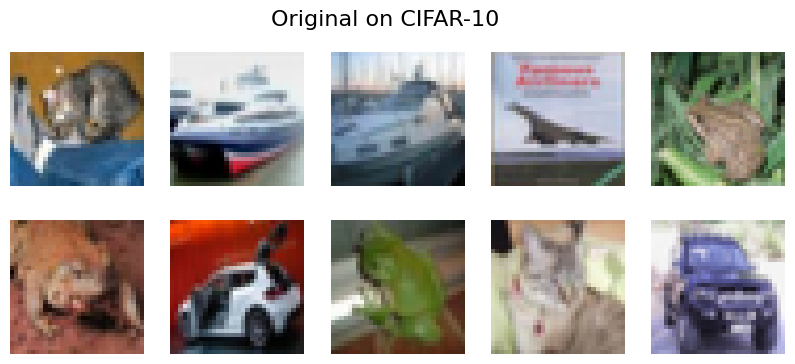

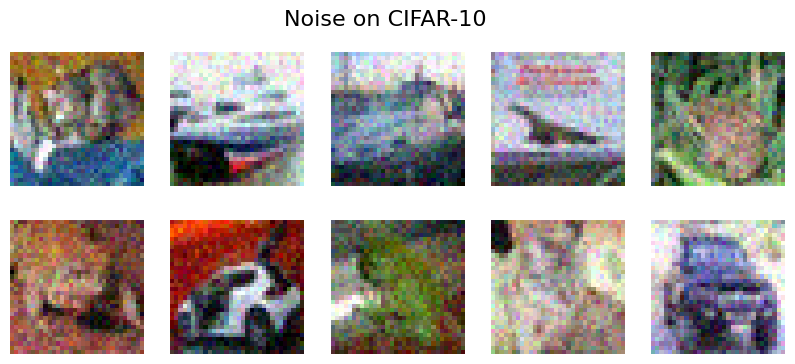

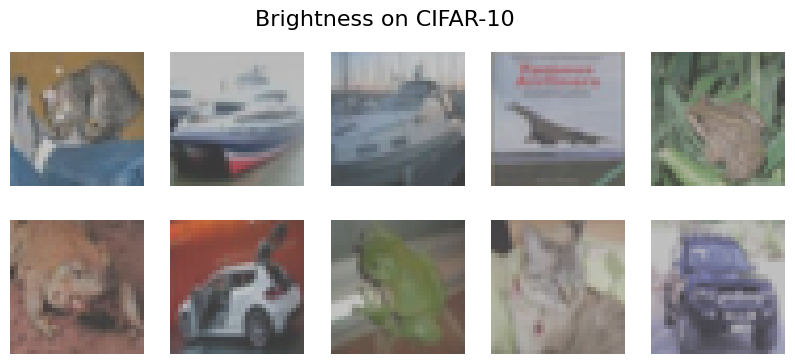

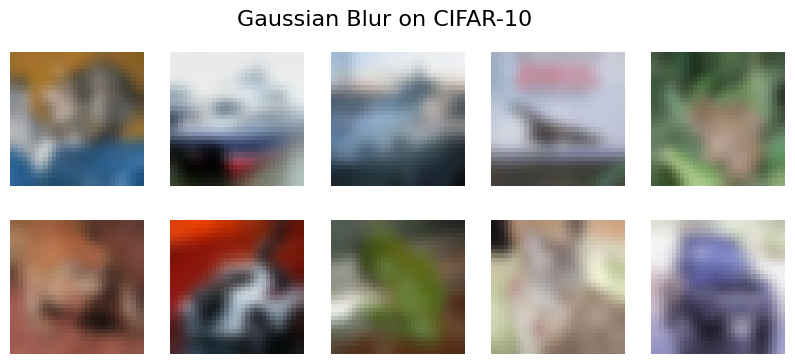

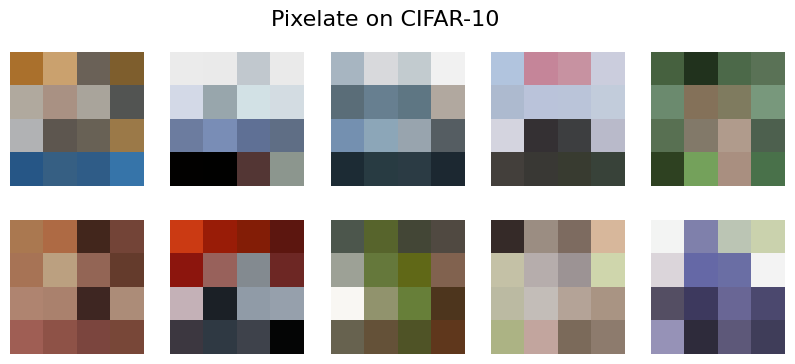

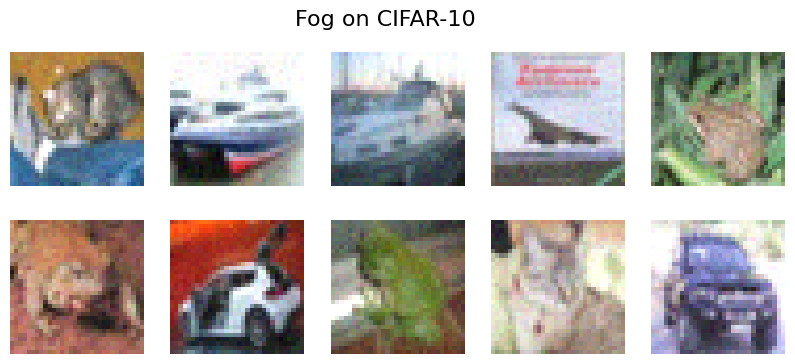

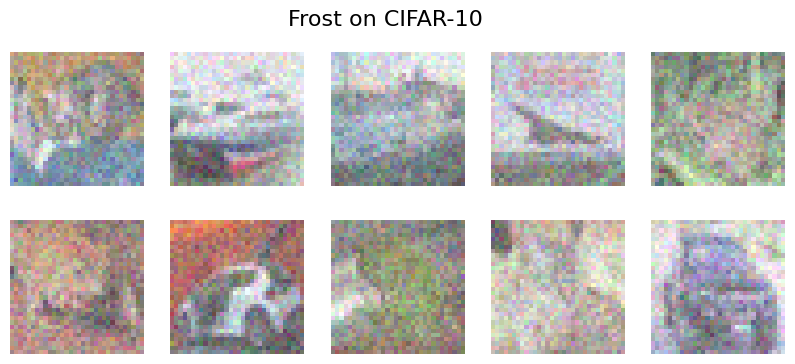

In [ ]:
SEVERITY = 3 #we have severity ranging 1-5, so choose the mid severity on these

dataiter = iter(testloader)
images, labels = next(dataiter)
images = images[:10]  #show 10 images

attacks = {
    "Original": images,
    "Noise": add_noise(images, SEVERITY),
    "Brightness": change_brightness(images, SEVERITY),
    "Gaussian Blur": defocus_blur(images, SEVERITY),
    "Pixelate": pixelate(images, SEVERITY),
    "Fog": add_fog(images, SEVERITY),
    "Frost": frost(images, SEVERITY)
}

for name, attacked_imgs in attacks.items():
    plt.figure(figsize=(10, 4))
    for i in range(10):
        img = attacked_imgs[i] / 2 + 0.5  #unnormalise
        npimg = img.cpu().numpy()
        plt.subplot(2, 5, i + 1)
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')
    plt.suptitle(f'{name} on CIFAR-10', size=16)
    plt.show()


So now we've effectively created our modified test sets hat can be used to test the model's robustness on the CIFAR-10 dataset. The modifications and attack choices were chosen due to teh fact the mirror modifications that we might encounter in a real world scenario.

We create a function to evaluate how the models perform with these pertubations.

In [ ]:
#we define a function that we can use to evaluate each of these 'scenarios' on our models
def evaluate_attack(model, attack_fn, testloader):
    accuracies = []
    model.eval()
    with torch.no_grad():
        for severity in SEVERITY_LEVELS:
            correct = total = 0
            for images, labels in testloader:
                images = attack_fn(images, severity)
                outputs = model(images.to(device))
                _, preds = torch.max(outputs, 1)
                correct += (preds.cpu() == labels).sum().item()
                total += labels.size(0)
            accuracies.append(100 * correct / total)
    return accuracies

The model architecture can be found at Report-> Supplementary -> Models

And the trained model weights can be found :
Report-> Supplementary -> Trained models.

First we load the ResNet18, the Plain18 and the ViT models.
We use a link directly to GitHub to load our files.


In [ ]:
file_path_resnet = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/Model_architecture/Resnet18.py"

resnet_code = requests.get(file_path_resnet, headers={'User-Agent': 'Mozilla/5.0'}).text
exec(resnet_code)
print("ResNet18.py loaded from GitHub")

ResNet18_acc_URL  = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/Trained_models/Resnet18_from_scratch/resnet18_cifar10_best_acc.pth"
ResNet18_loss_URL = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/Trained_models/Resnet18_from_scratch/resnet18_cifar10_best_loss.pth"

ResNet18_acc_PATH  = "resnet18_cifar10_best_acc.pth"
ResNet18_loss_PATH = "resnet18_cifar10_best_loss.pth"

for url, filename in [(ResNet18_acc_URL, ResNet18_acc_PATH), (ResNet18_loss_URL, ResNet18_loss_PATH)]:
    r = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    with open(filename, "wb") as f:
        f.write(r.content)

print("ResNet18 weights downloaded from GitHub")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_res_acc  = ResNet18(num_classes=10).to(device)
model_res_loss = ResNet18(num_classes=10).to(device)

state_res_acc  = torch.load(ResNet18_acc_PATH,  map_location=device, weights_only=False)
state_res_loss = torch.load(ResNet18_loss_PATH, map_location=device, weights_only=False)

missing_acc  = model_res_acc.load_state_dict(state_res_acc,  strict=False)
missing_loss = model_res_loss.load_state_dict(state_res_loss, strict=False)

model_res_acc.eval()
model_res_loss.eval()

print("ResNet18 models loaded successfully from GitHub!")




ResNet18.py loaded from GitHub
ResNet18 weights downloaded from GitHub
ResNet18 models loaded successfully from GitHub!


In [ ]:
#we load our model from github
file_path_plain = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/Model_architecture/Plain18.py"

plain_code = requests.get(file_path_plain).text
exec(plain_code)
print("Plain18.py loaded from GitHub")

plain18_acc_URL  = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/Trained_models/Plain18_from_scratch/plain18_cifar10_best_acc.pth"
plain18_loss_URL = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/Trained_models/Plain18_from_scratch/plain18_cifar10_best_loss.pth"

plain18_acc_PATH  = "plain18_cifar10_best_acc.pth"
plain18_loss_PATH = "plain18_cifar10_best_loss.pth"
for url, filename in [(plain18_acc_URL, plain18_acc_PATH), (plain18_loss_URL, plain18_loss_PATH)]:
    r = requests.get(url)
    with open(filename, "wb") as f:
        f.write(r.content)
print("Plain18 weights downloaded")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_plain_acc  = Plain18(num_classes=10).to(device)
model_plain_loss = Plain18(num_classes=10).to(device)

state_plain_acc  = torch.load(plain18_acc_PATH, map_location=device)
state_plain_loss = torch.load(plain18_loss_PATH, map_location=device)

model_plain_acc.load_state_dict(state_plain_acc)
model_plain_loss.load_state_dict(state_plain_loss)

model_plain_acc.eval()
model_plain_loss.eval()

print("Plain18 best-acc and best-loss models loaded successfully from GitHub!")


Plain18.py loaded from GitHub
Plain18 weights downloaded
Plain18 best-acc and best-loss models loaded successfully from GitHub!


In [ ]:
file_path_vit = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/Model_architecture/SL_Vit.py"
vit_code = requests.get(file_path_vit, headers={'User-Agent': 'Mozilla/5.0'}).text
exec(vit_code)
print("SL_ViT architecture loaded successfully from GitHub!")

Vit_acc_URL  = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/Trained_models/SLViT_from_scratch/slvit_cifar10_best_acc.pth"
Vit_loss_URL = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/Trained_models/SLViT_from_scratch/slvit_cifar10_best_loss.pth"

Vit_acc_PATH  = "slvit_cifar10_best_acc.pth"
Vit_loss_PATH = "slvit_cifar10_best_loss.pth"

for url, filename in [(Vit_acc_URL, Vit_acc_PATH), (Vit_loss_URL, Vit_loss_PATH)]:
    r = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    with open(filename, "wb") as f:
        f.write(r.content)

print("SL_ViT weights downloaded from GitHub")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_vit_acc = ViT(
    image_size=32, patch_size=4, num_classes=10,
    dim=256, depth=6, heads=8, mlp_dim=512,
    dropout=0.1, emb_dropout=0.1
).to(device)

model_vit_loss = ViT(
    image_size=32, patch_size=4, num_classes=10,
    dim=256, depth=6, heads=8, mlp_dim=512,
    dropout=0.1, emb_dropout=0.1
).to(device)

state_vit_acc  = torch.load(Vit_acc_PATH,  map_location=device, weights_only=False)
state_vit_loss = torch.load(Vit_loss_PATH, map_location=device, weights_only=False)

missing_acc  = model_vit_acc.load_state_dict(state_vit_acc,  strict=False)
missing_loss = model_vit_loss.load_state_dict(state_vit_loss, strict=False)

model_vit_acc.eval()
model_vit_loss.eval()

print("SL_ViT best-ACC and best-LOSS models loaded successfully!")


SL_ViT architecture loaded successfully from GitHub!
SL_ViT weights downloaded from GitHub
SL_ViT best-ACC and best-LOSS models loaded successfully!


Now we evaluate for each model:

In [ ]:
#evaluating for resnet18
attack_results_Res_acc = {
    "Noise":       evaluate_attack(model_res_acc, add_noise, testloader),
    "Brightness":  evaluate_attack(model_res_acc, change_brightness, testloader),
    "Blur":        evaluate_attack(model_res_acc, defocus_blur, testloader),
    "Pixelate":    evaluate_attack(model_res_acc, pixelate, testloader),
    "Fog":         evaluate_attack(model_res_acc, add_fog, testloader),
    "Frost":       evaluate_attack(model_res_acc, frost, testloader),
}

attack_results_Res_loss = {
    "Noise":       evaluate_attack(model_res_loss, add_noise, testloader),
    "Brightness":  evaluate_attack(model_res_loss, change_brightness, testloader),
    "Blur":        evaluate_attack(model_res_loss, defocus_blur, testloader),
    "Pixelate":    evaluate_attack(model_res_loss, pixelate, testloader),
    "Fog":         evaluate_attack(model_res_loss, add_fog, testloader),
    "Frost":       evaluate_attack(model_res_loss, frost, testloader),
}


In [ ]:
#evaluating for transformer
attack_results_Vit_acc = {
    "Noise":       evaluate_attack(model_vit_acc, add_noise, testloader),
    "Brightness":  evaluate_attack(model_vit_acc, change_brightness, testloader),
    "Blur":        evaluate_attack(model_vit_acc, defocus_blur, testloader),
    "Pixelate":    evaluate_attack(model_vit_acc, pixelate, testloader),
    "Fog":         evaluate_attack(model_vit_acc, add_fog, testloader),
    "Frost":       evaluate_attack(model_vit_acc, frost, testloader),
}


attack_results_Vit_loss = {
    "Noise":       evaluate_attack(model_vit_loss, add_noise, testloader),
    "Brightness":  evaluate_attack(model_vit_loss, change_brightness, testloader),
    "Blur":        evaluate_attack(model_vit_loss, defocus_blur, testloader),
    "Pixelate":    evaluate_attack(model_vit_loss, pixelate, testloader),
    "Fog":         evaluate_attack(model_vit_loss, add_fog, testloader),
    "Frost":       evaluate_attack(model_vit_loss, frost, testloader),
}



In [ ]:
#evaluating for plain18
attack_results_plain_acc = {
    "Noise":       evaluate_attack(model_plain_acc, add_noise, testloader),
    "Brightness":  evaluate_attack(model_plain_acc, change_brightness, testloader),
    "Blur":        evaluate_attack(model_plain_acc, defocus_blur, testloader),
    "Pixelate":    evaluate_attack(model_plain_acc, pixelate, testloader),
    "Fog":         evaluate_attack(model_plain_acc, add_fog, testloader),
    "Frost":       evaluate_attack(model_plain_acc, frost, testloader),
}


attack_results_plain_loss = {
    "Noise":       evaluate_attack(model_plain_loss, add_noise, testloader),
    "Brightness":  evaluate_attack(model_plain_loss, change_brightness, testloader),
    "Blur":        evaluate_attack(model_plain_loss, defocus_blur, testloader),
    "Pixelate":    evaluate_attack(model_plain_loss, pixelate, testloader),
    "Fog":         evaluate_attack(model_plain_loss, add_fog, testloader),
    "Frost":       evaluate_attack(model_plain_loss, frost, testloader),
}

This results in the following plot, were we plot the accuracy of the models against the severity of the robustness test:

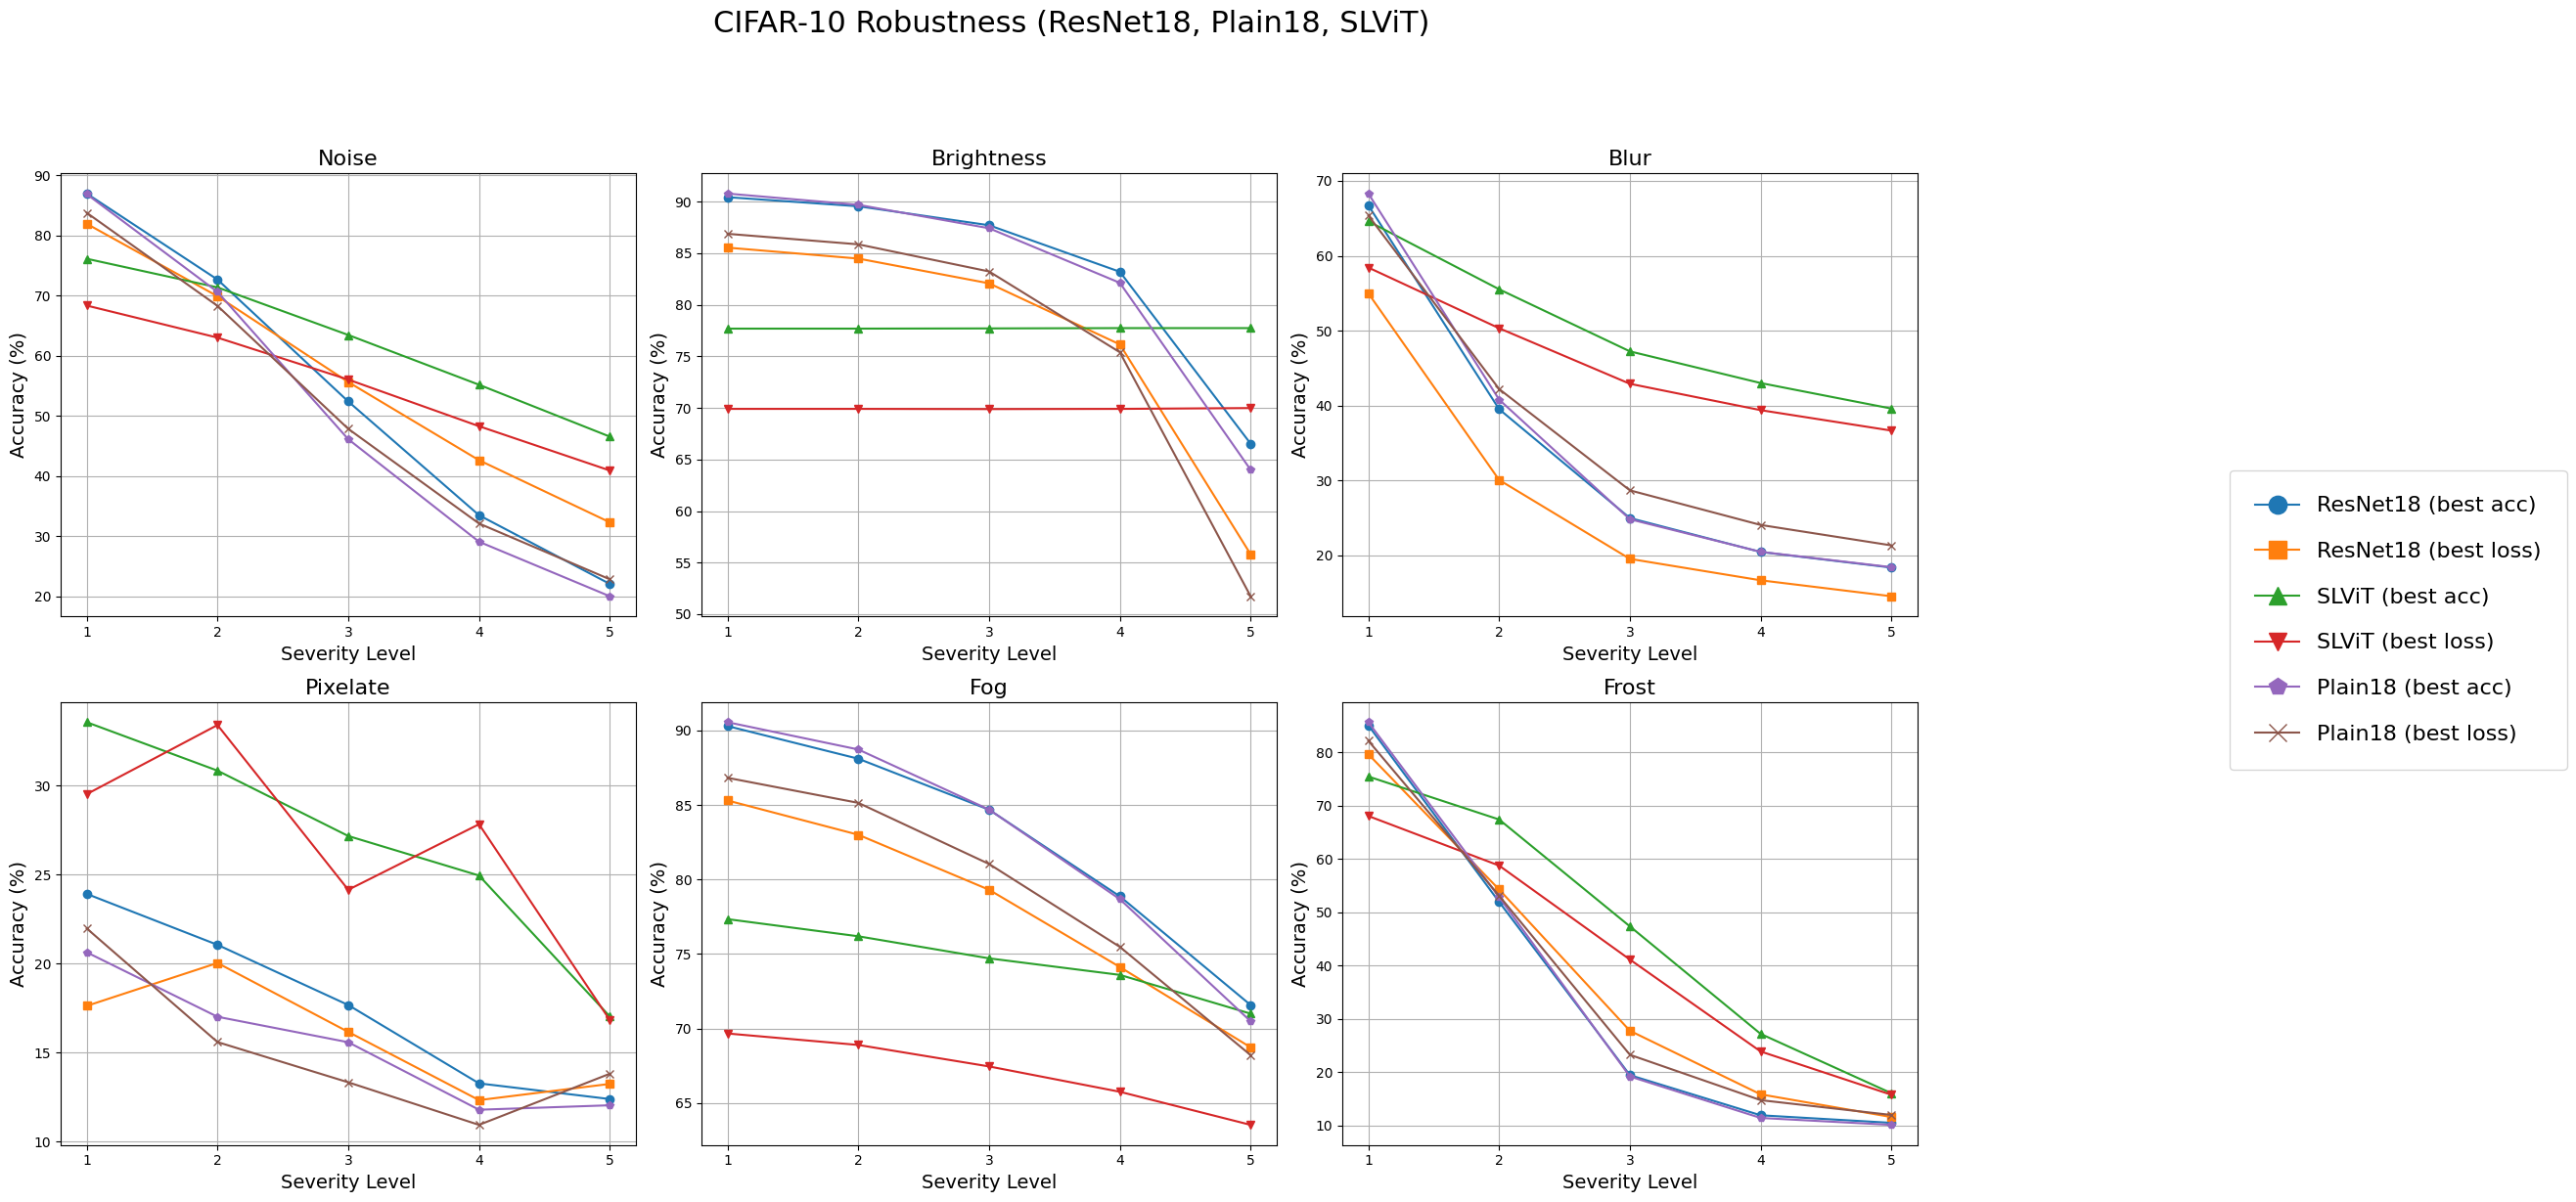

In [ ]:
attacks = list(attack_results_Res_acc.keys())
num_attacks = len(attacks)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(22, 12))
axes = axes.flatten()

for idx, attack_name in enumerate(attacks):
    ax = axes[idx]

    #curves for each
    acc_curve_res   = attack_results_Res_acc[attack_name]
    loss_curve_res  = attack_results_Res_loss[attack_name]
    acc_curve_vit   = attack_results_Vit_acc[attack_name]
    loss_curve_vit  = attack_results_Vit_loss[attack_name]
    acc_curve_plain = attack_results_plain_acc[attack_name]
    loss_curve_plain = attack_results_plain_loss[attack_name]

    #plotting
    ax.plot(SEVERITY_LEVELS, acc_curve_res,   marker='o', label='ResNet18 (best acc)')
    ax.plot(SEVERITY_LEVELS, loss_curve_res,  marker='s', label='ResNet18 (best loss)')
    ax.plot(SEVERITY_LEVELS, acc_curve_vit,   marker='^', label='SLViT (best acc)')
    ax.plot(SEVERITY_LEVELS, loss_curve_vit,  marker='v', label='SLViT (best loss)')
    ax.plot(SEVERITY_LEVELS, acc_curve_plain, marker='p', label='Plain18 (best acc)')
    ax.plot(SEVERITY_LEVELS, loss_curve_plain, marker='x', label='Plain18 (best loss)')

    ax.set_title(attack_name, fontsize=16)
    ax.set_xlabel("Severity Level", fontsize=14)
    ax.set_ylabel("Accuracy (%)", fontsize=14)
    ax.set_xticks(SEVERITY_LEVELS)
    ax.grid(True)

for j in range(idx + 1, len(axes)):
    axes[j].axis('off')
plt.suptitle("CIFAR-10 Robustness (ResNet18, Plain18, SLViT)", fontsize=22, y=1.02)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='center right',
    bbox_to_anchor=(1.0, 0.5),
    fontsize=16,
    markerscale=2.2,
    borderpad=1.2,
    labelspacing=1.2
)

plt.tight_layout(rect=[0, 0, 0.93, 0.95])

plt.show()



The above plot shows how model accuracies compare under different severities of image corruption on CIFAR-10. As we expect, we can clearly see that accuracy decreases with severity of the image pertubation,.

For noise, there is an approximately negative linear trend for accuracy against severity, we see each model reduces accuracy with severity. SLViT_best_acc (best accuracy) remains the strongest overall, holding its performance higher than both ResNet18 and Plain18 at every level, while the loss-selected versions of each model follow a similar downward slope but at slightly lower accuracy.

For brightness we observe that neither of the SLViT models are affected, this is perhaps due to the fact that SLViT architectures rely less on raw pixel intensities and more on global structure, so uniform brightness changes do not disrupt their internal representations.
Meanwhile the remaining models perform gradually worse with severity, dropping sharply at severity level 5, showing the CNNs (Plain18 and ResNet18) are more affected by the changes in brightness since they focus more strongly on local edge and texture information.  

For blur most models perform well for severity 1, but decrease strongly with severity. Each model has a similar trend, with the Plain18 models and ResNet18_best_acc all losing accuracy quickly after severity level 2, since we lose high frequency details with severity.

Pixelate is the hardest to distinguish, leading to a lower accuracy for all models. But interestingly SLViT_best_loss performs worse then has an increase in accuracy at severity 4, before performing badly again. This could be because moderate pixelation sometimes preserves enough coarse structure for the transformer to recognise, but both low and extreme pixelation levels obscure too much of the image.

For fog and frost we once again have that most models perform similarly, with a general downward trend, with the exception of SLViT that perform slightly worse for fog and slightly better for frost, suggesting stronger robustness to the visual clutter introduced by frost patterns.

Overall, these results show that while all models decrease in accuracy with severity, SLViT consistently performs better (accuracy-wise), with a greater resistance to our robustness attacks. Hence transformer-based architectures might generalise better under real-world distortion than traditional CNNs such as ResNet18 and Plain18.



#Robustness on Food 101
Despite the fact these images are collected from a real world scenario, hence already including varied brightnesses and blur, we enhance these to test the robustness of our models.

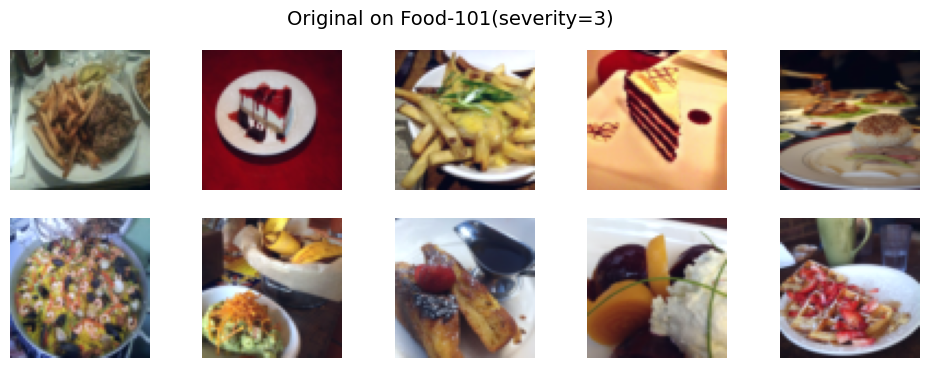

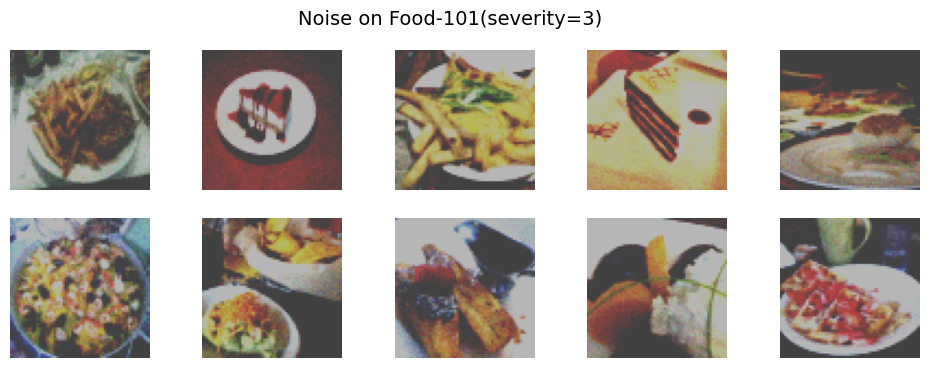

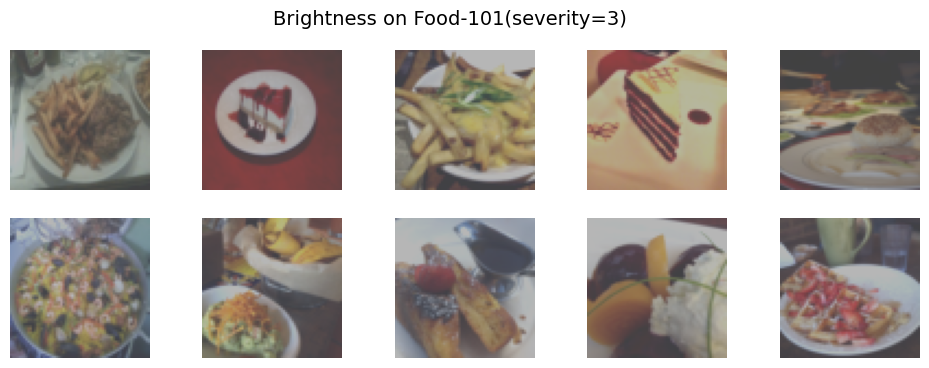

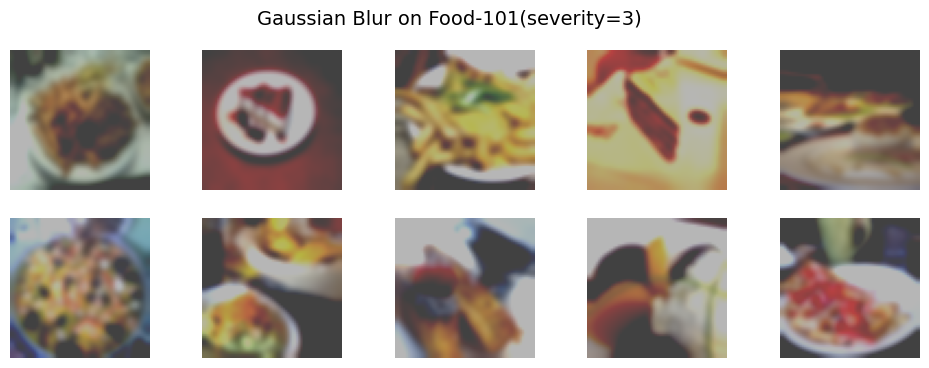

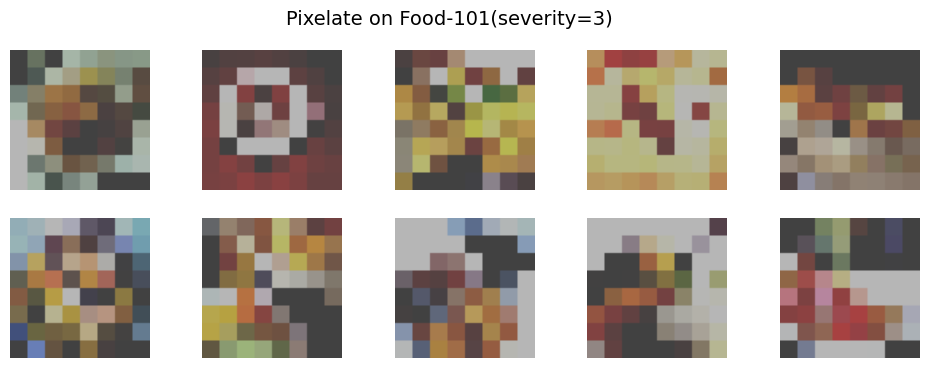

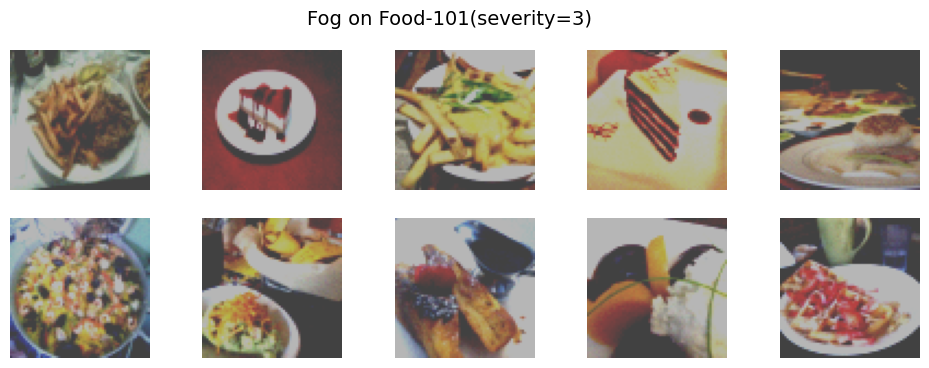

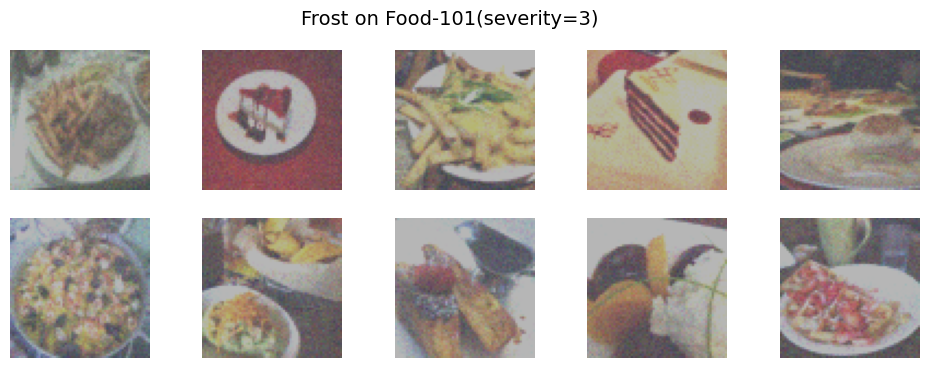

In [ ]:
# Get one batch of tensors directly from DataLoader (images are already tensors)
images, labels = next(iter(train_loader64))

# Optional: use only first 10 images for plotting
images_64 = images[:10].clone()
labels_64 = labels[:10].clone()

# Apply corruptions
modifications = {
    "Original":      images_64,
    "Noise":         add_noise(images_64, severity=3),
    "Brightness":    change_brightness(images_64, severity=3),
    "Gaussian Blur": defocus_blur(images_64, severity=3),
    "Pixelate":      pixelate(images_64, severity=3),
    "Fog":           add_fog(images_64, severity=3),
    "Frost":         frost(images_64, severity=3)
}

# Visualise results
for name, attacked_imgs in modifications.items():
    plt.figure(figsize=(12, 4))
    for i in range(len(attacked_imgs)):
        img = attacked_imgs[i].cpu()  # bring back from GPU if needed
        img = img * 0.229 + 0.485  # undo normalization (approx.)
        npimg = img.numpy().transpose(1, 2, 0)

        plt.subplot(2, 5, i + 1)
        plt.imshow(npimg)
        plt.axis('off')

    plt.suptitle(f'{name} on Food-101(severity=3)', fontsize=14)
    plt.show()




Now we apply our neural networks to our adversarial attack datasets, the results can be seen in the visualisation below. But first we must load the models.





In [ ]:
file_path_resnet = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/Model_architecture/Resnet18.py"

resnet_code = requests.get(file_path_resnet, headers={'User-Agent': 'Mozilla/5.0'}).text
exec(resnet_code)
print("ResNet18 architecture loaded successfully!")

ResNet18_food_URL = (
    "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/"
    "Report/Supplementary/Trained_models/Resnet18_from_scratch/resnet18_food101_best.pth"
)

ResNet18_food_PATH = "resnet18_food101_best.pth"

r = requests.get(ResNet18_food_URL, headers={'User-Agent': 'Mozilla/5.0'})
with open(ResNet18_food_PATH, "wb") as f:
    f.write(r.content)

print(f"Food-101 weights downloaded (Size: {os.path.getsize(ResNet18_food_PATH)} bytes)")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_food_res = ResNet18(num_classes=101).to(device)

state_food_res = torch.load(
    ResNet18_food_PATH,
    map_location=device,
    weights_only=False
)

missing_keys = model_food_res.load_state_dict(state_food_res, strict=False)



ResNet18 architecture loaded successfully!
Food-101 weights downloaded (Size: 44963403 bytes)
Missing keys: []
Model loaded successfully!


ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, mo

In [ ]:
file_path_vit = (
    "https://raw.githubusercontent.com/K-Chorna02/"
    "DST_Assessment_2/main/Report/Supplementary/Model_architecture/SL_Vit.py"
)

vit_code = requests.get(file_path_vit, headers={'User-Agent': 'Mozilla/5.0'}).text
exec(vit_code)
print("SLViT architecture loaded successfully from GitHub!")

Vit_food_URL = (
    "https://raw.githubusercontent.com/K-Chorna02/"
    "DST_Assessment_2/main/Report/Supplementary/Trained_models/SLViT_from_scratch/slvit_food101_best.pth"
)

Vit_food_PATH = "slvit_food101_best.pth"

r = requests.get(Vit_food_URL, headers={'User-Agent': 'Mozilla/5.0'})
with open(Vit_food_PATH, "wb") as f:
    f.write(r.content)

print(f"Food-101 ViT weights downloaded (Size: {os.path.getsize(Vit_food_PATH)} bytes)")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def make_food_vit():
    return ViT(
        image_size=64, patch_size=8, num_classes=101,
        dim=256, depth=6, heads=8, mlp_dim=512,
        dropout=0.1, emb_dropout=0.1
    )

model_vit_food = make_food_vit().to(device)

state_vit_food = torch.load(
    Vit_food_PATH,
    map_location=device,
    weights_only=False
)


model_vit_food.eval()

print("SLViT Food-101 model loaded successfully!")


SLViT architecture loaded successfully from GitHub!
Food-101 ViT weights downloaded (Size: 20122997 bytes)
Missing keys: []
SLViT Food-101 model loaded successfully!


In [ ]:
attack_results_Food101_ResNet_best = {
    "Noise":       evaluate_attack(model_food_res, add_noise, test_loader64),
    "Brightness":  evaluate_attack(model_food_res, change_brightness, test_loader64),
    "Blur":        evaluate_attack(model_food_res, defocus_blur, test_loader64),
    "Pixelate":    evaluate_attack(model_food_res, pixelate, test_loader64),
    "Fog":         evaluate_attack(model_food_res, add_fog, test_loader64),
    "Frost":       evaluate_attack(model_food_res, frost, test_loader64),
}


In [ ]:
attack_results_Food101_ViT_best = {
    "Noise":       evaluate_attack(model_vit_food, add_noise, test_loader64),
    "Brightness":  evaluate_attack(model_vit_food, change_brightness, test_loader64),
    "Blur":        evaluate_attack(model_vit_food, defocus_blur, test_loader64),
    "Pixelate":    evaluate_attack(model_vit_food, pixelate, test_loader64),
    "Fog":         evaluate_attack(model_vit_food, add_fog, test_loader64),
    "Frost":       evaluate_attack(model_vit_food, frost, test_loader64),
}

In [ ]:
plt.suptitle("Food-101 Robustness (ResNet18 vs SLViT)", fontsize=16, y=1.02)

attacks = list(attack_results_Food101_ResNet_best.keys())
num_attacks = len(attacks)

rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(14, 8))
axes = axes.flatten()

for idx, attack_name in enumerate(attacks):
    ax = axes[idx]
    acc_curve_resnet = attack_results_Food101_ResNet_best[attack_name]#curves for each
    acc_curve_vit    = attack_results_Food101_ViT_best[attack_name]
    ax.plot(SEVERITY_LEVELS, acc_curve_resnet, marker='o', label='ResNet18')#plotting
    ax.plot(SEVERITY_LEVELS, acc_curve_vit,    marker='s', label='SLViT')

    ax.set_title(attack_name)
    ax.set_xlabel("Severity Level")
    ax.set_ylabel("Accuracy (%)")
    ax.set_xticks(SEVERITY_LEVELS)
    ax.grid(True)
    ax.legend(fontsize=8)

# Hide any unused axes
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()



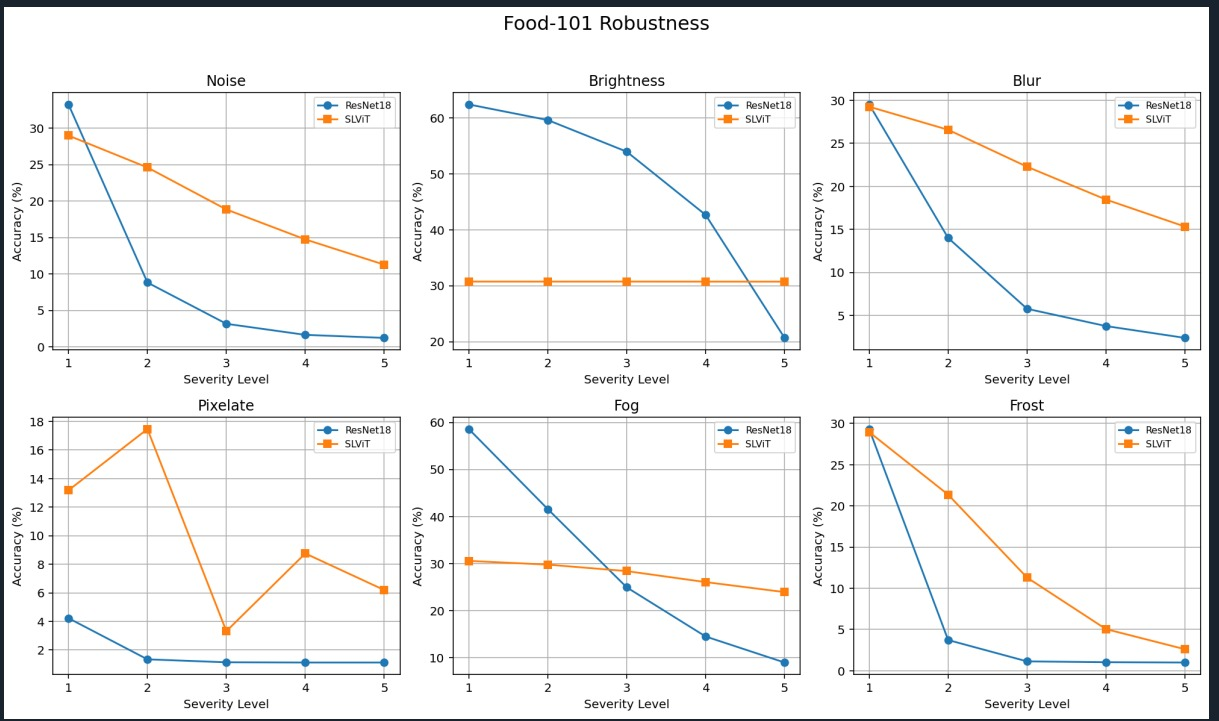

Since this code takes a long time to run, we have included the visualisation shown above, this shows how ResNet18 and ViT perform across our image corruptions. For the food101 dataset we were restrained by our GPU limitations so were only able to run ResNet18 and SLViT for robustness tests, rather than Plain18 and rather than breaking our models down into best accuracy and best loss.

This clearly shows that performance is worse for the pixelation corruption, which is to be expected as this is the hardest transformation to interpret.
As we saw earlier for CIFAR-10, SLViT is not affected by the brightness transformation, with the accuracy remaining constant across severity levels, meanwhile  ResNet18's performance decreases in accuracy as the severity increases (darkness increases).
Similarly, for Fog, SLViT remains at a lower accuracy and only decreases very slightly with severity, with ResNet18 performing better at first until severity level 3, where it drops below SLViT. This suggests that the model architecture of SLViT captures more stable features than the convolution based ResNet18.

For noise and blur, SLViT performs better with a more gradual decrease in accuracy and a substantially higher accuracy at all levels. This is most like due to the fact ViT models do not depend as heavily on smaller texture details, and instead focus on broader patterns across the whole image. Hence despite these distortions, the model does a better job of looking at the image as a whole than ResNet18.

Overall, we see that SLViT is consistently more robust than ResNet18 across nearly all corruptions, as we saw for CIFAR-10. This shows that it provides stronger resilience to real-world corruptions and is a more robust method on the Food101 dataset.
In terms of scalability, we have tested these results on CIFAR-10 and a more realistic dataset, Food101, and found that SLViT still maintains stronger generalisation properties, stronger robustness and relatively high accuracy. If we were to scale to an even more complex dataset, we would expect to favour SLViT models over ResNet18 models.



# t-SNE on CIFAR-10 Gaussian noise
To clearly visualise how the model separates classes and the effect of noise on the model's performance, we use t-distributed Stochastic Neighbor Embedding (t-SNE). Unlike linear methods such as PCA that we used in the EDA, this approach allows us to capture non-linear relationships by keeping the local structure of data points.
We apply t-SNE to feature vectors that we extracted from the penultimate layer.

We produce 3 plots, one for ResNet18 applied directly to clean CIFAR-10, one where we have applied Gaussian noise applied to severity 1 and another at severity 5.
This allows us to clearly see the degregation of class distribution with distortion such as Gaussian noise.


#### t-SNE on ResNet18 for CIFAR-10

Extracting (noise=5): 100%|██████████| 100/100 [00:00<00:00, 212.01it/s]


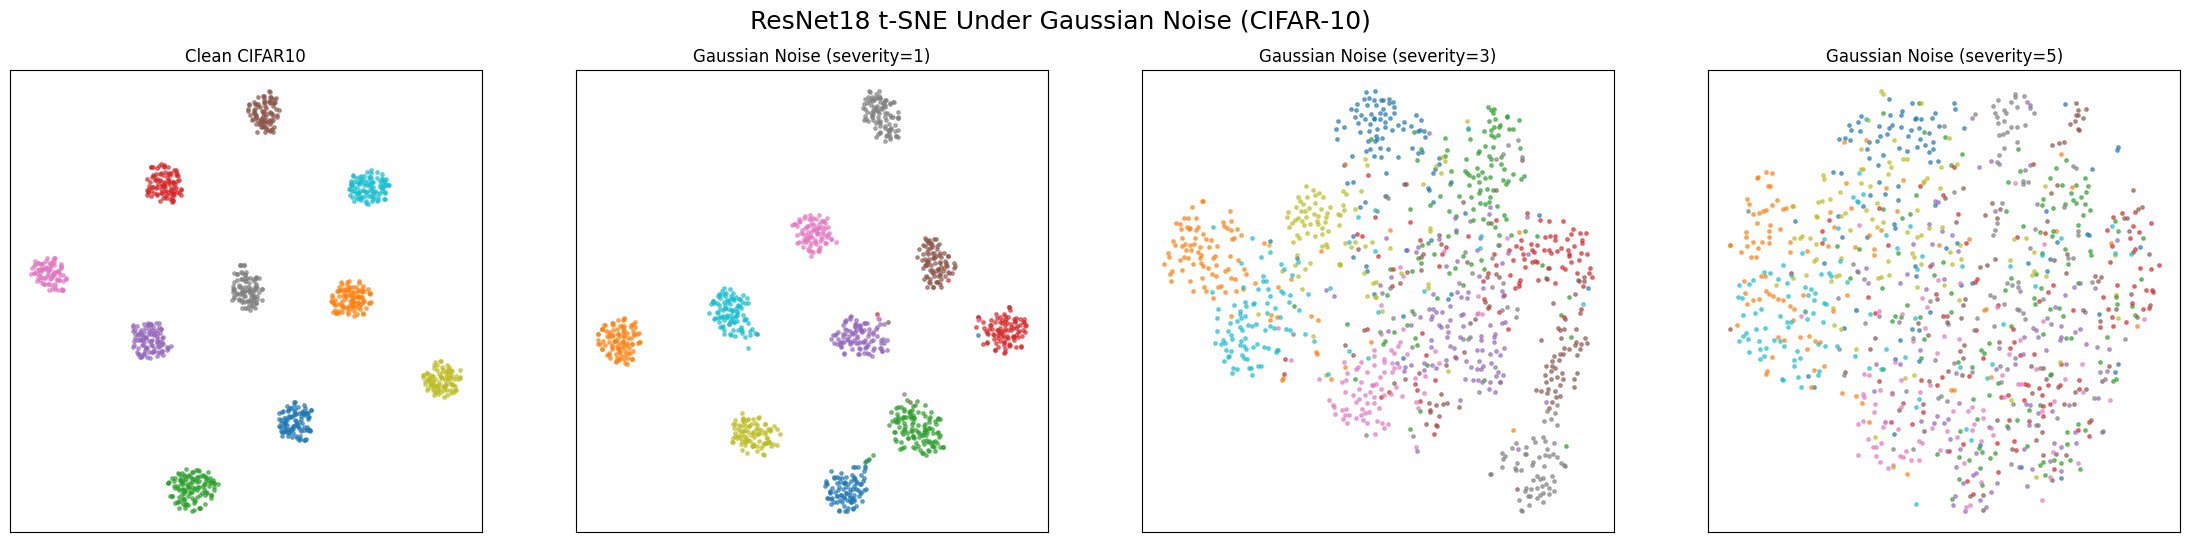

In [ ]:
def get_small_loader(dataloader, num_batches=100):
    small_data = []
    for i, batch in enumerate(dataloader):
        if i >= num_batches:
            break
        small_data.append(batch)
    return small_data

small_train = get_small_loader(trainloader)

#extractor
feature_extractor_res = torch.nn.Sequential(*list(model_res_acc.children())[:-1])

def extract_features(dataloader, noise_severity=None):
    model_res_acc.eval()
    features, labels = [], []

    with torch.no_grad():
        for images, lbls in tqdm(dataloader, desc=f"Extracting (noise={noise_severity})"):
            images = images.to(device)
            if noise_severity is not None:
                images = add_noise(images, severity=noise_severity)

            feats = feature_extractor_res(images).squeeze()
            features.append(feats.cpu().numpy())
            labels.extend(lbls.numpy())

    return np.vstack(features), np.array(labels)

#extracting for severities 0,1,3,5
clean_feats, clean_lbls = extract_features(small_train, noise_severity=None)
s1_feats, s1_lbls = extract_features(small_train, noise_severity=1)
s3_feats, s3_lbls = extract_features(small_train, noise_severity=3)
s5_feats, s5_lbls = extract_features(small_train, noise_severity=5)

def tsne_single(features):
    pca = PCA(n_components=50)
    reduced = pca.fit_transform(features)
    tsne = TSNE(n_components=2, random_state=42, init='pca')
    return tsne.fit_transform(reduced)

clean_tsne = tsne_single(clean_feats)
s1_tsne    = tsne_single(s1_feats)
s3_tsne    = tsne_single(s3_feats)
s5_tsne    = tsne_single(s5_feats)

fig, axes = plt.subplots(1, 4, figsize=(28, 6))

def plot_single(ax, X, labels, title):
    classes = trainset.classes
    for i, cls in enumerate(classes):
        idx = labels == i
        ax.scatter(X[idx, 0], X[idx, 1], s=6, alpha=0.6)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])

plot_single(axes[0], clean_tsne, clean_lbls, "Clean CIFAR10")
plot_single(axes[1], s1_tsne,   s1_lbls,   "Gaussian Noise (severity=1)")
plot_single(axes[2], s3_tsne,   s3_lbls,   "Gaussian Noise (severity=3)")
plot_single(axes[3], s5_tsne,   s5_lbls,   "Gaussian Noise (severity=5)")

plt.suptitle("ResNet18 t-SNE Under Gaussian Noise (CIFAR-10)", fontsize=18)
plt.show()


As we see in the clean CIFAR-10 ResNet18, there are 10 clear, well separated clusters for each class. This suggests that the model successfully learnt clear and distinguished classes. As we increase the severity of Gaussian noise, we see the clusters become less clear.
For the first severity level, the structure remains mostly the same as the effects of the noise have been minimal. For severity 3 the clusters begin to disperse and overlap slightly more,  and by the time we are at severity 5 the clusters have become intertwined and the classes are no longer distinguishable, showing that when we apply a large amount of Gaussian noise, showing the model can no longer extract meaningful class distributions.


#### t-SNE on ViT for CIFAR-10

Extracting features (noise=5): 100%|██████████| 100/100 [00:00<00:00, 179.34it/s]


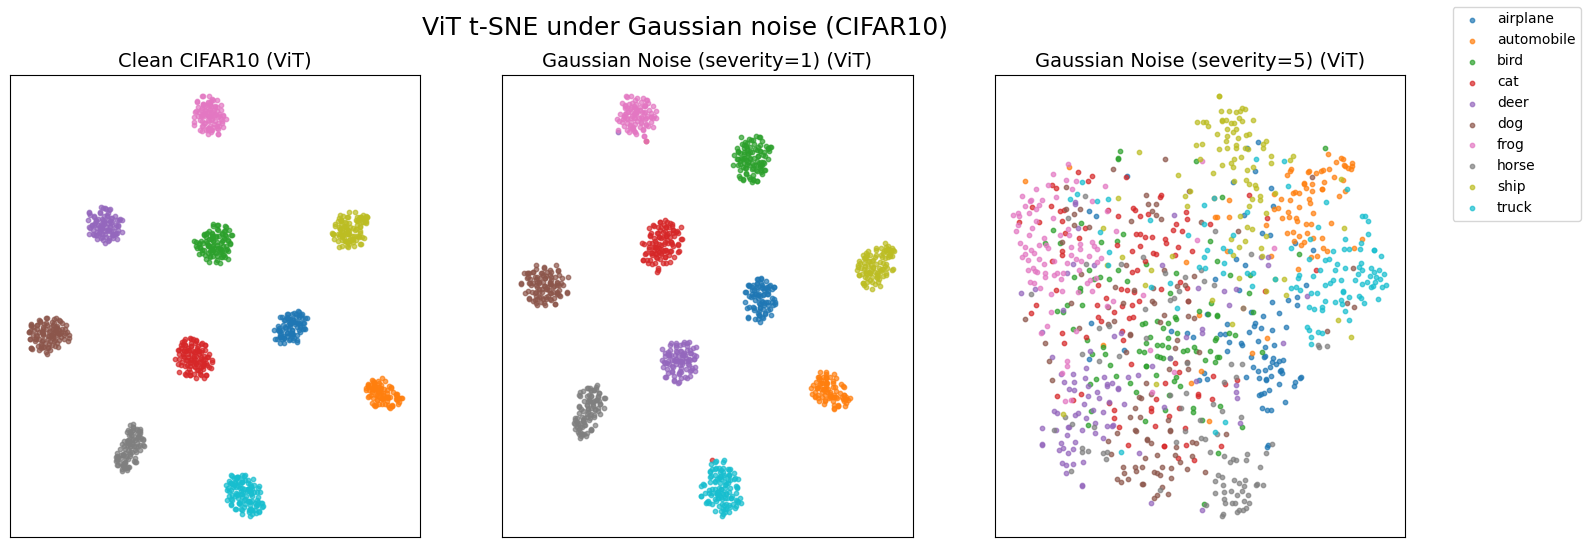

In [ ]:
def get_small_loader(dataloader, num_batches=100):
    small_data = []
    for i, batch in enumerate(dataloader):
        if i >= num_batches:
            break
        small_data.append(batch)
    return small_data

small_train = get_small_loader(trainloader, num_batches=100)

def vit_forward_features(model, images):
    x = model.to_patch_embedding(images)
    b, n, _ = x.shape
    cls_tokens = model.cls_token.expand(b, -1, -1)
    x = torch.cat((cls_tokens, x), dim=1)
    x = x + model.pos_embedding[:, :(n + 1)]
    x = model.dropout(x)
    x = model.transformer(x)
    if model.pool == 'mean':
        x = x.mean(dim=1)
    else:
        x = x[:, 0]

    return model.to_latent(x)

def extract_vit_features(dataloader, noise_severity=None, max_points=5000):
    model_vit_acc.eval()
    features, labels = [], []
    total = 0

    with torch.no_grad():
        for images, lbls in tqdm(dataloader, desc=f"Extracting features (noise={noise_severity})"):
            images = images.to(device)
            if noise_severity is not None:
                images = add_noise(images, severity=noise_severity)

            feats = vit_forward_features(model_vit_acc, images)  # (B, dim)

            features.append(feats.cpu())
            labels.append(lbls)

            total += lbls.size(0)
            if total >= max_points:
                break

    features = torch.cat(features)[:max_points].numpy()
    labels   = torch.cat(labels)[:max_points].numpy()
    return features, labels

#we vary severity as 0, 1,5
clean_feats_vit,  clean_lbls_vit  = extract_vit_features(small_train, noise_severity=None)
noisy1_feats_vit, noisy1_lbls_vit = extract_vit_features(small_train, noise_severity=1)
noisy5_feats_vit, noisy5_lbls_vit = extract_vit_features(small_train, noise_severity=5)

def tsne_single(features):
    pca = PCA(n_components=50)
    reduced = pca.fit_transform(features)
    tsne = TSNE(n_components=2, random_state=42, init='pca')
    return tsne.fit_transform(reduced)

clean_tsne_vit  = tsne_single(clean_feats_vit)
noisy1_tsne_vit = tsne_single(noisy1_feats_vit)
noisy5_tsne_vit = tsne_single(noisy5_feats_vit)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

def plot_single(ax, X, labels, title):
    classes = trainset.classes
    for i, cls in enumerate(classes):
        idx = labels == i
        ax.scatter(X[idx, 0], X[idx, 1], s=10, alpha=0.7, label=cls)
    ax.set_title(title, fontsize=14)
    ax.set_xticks([]); ax.set_yticks([])

plot_single(axes[0], clean_tsne_vit,  clean_lbls_vit,  "Clean CIFAR10 (ViT)")
plot_single(axes[1], noisy1_tsne_vit, noisy1_lbls_vit, "Gaussian Noise (severity=1) (ViT)")
plot_single(axes[2], noisy5_tsne_vit, noisy5_lbls_vit, "Gaussian Noise (severity=5) (ViT)")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.suptitle("ViT t-SNE under Gaussian noise (CIFAR10)", fontsize=18)
plt.show()



Similarly for the ViT t-SNE, we see that as we increase the severity of Gaussian noise, we see the clusters become less clear.

#Visualisation of convolutional layers on ResNet18

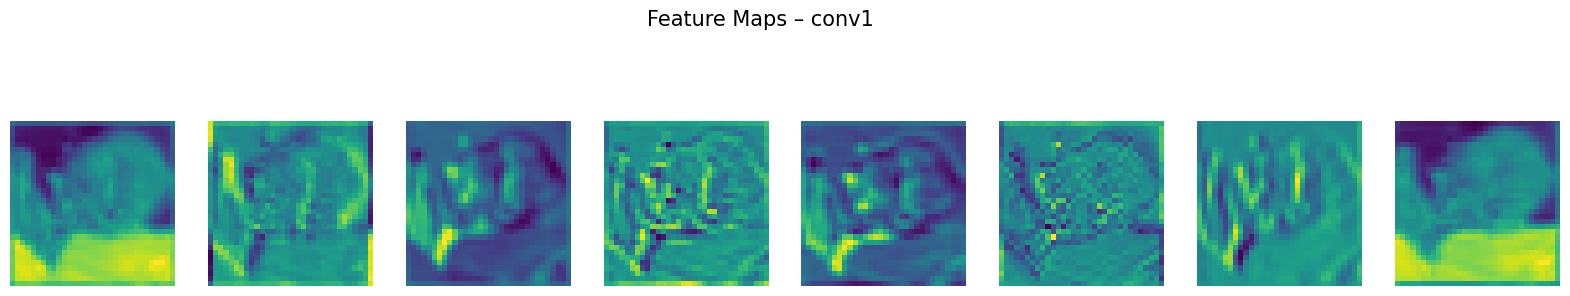

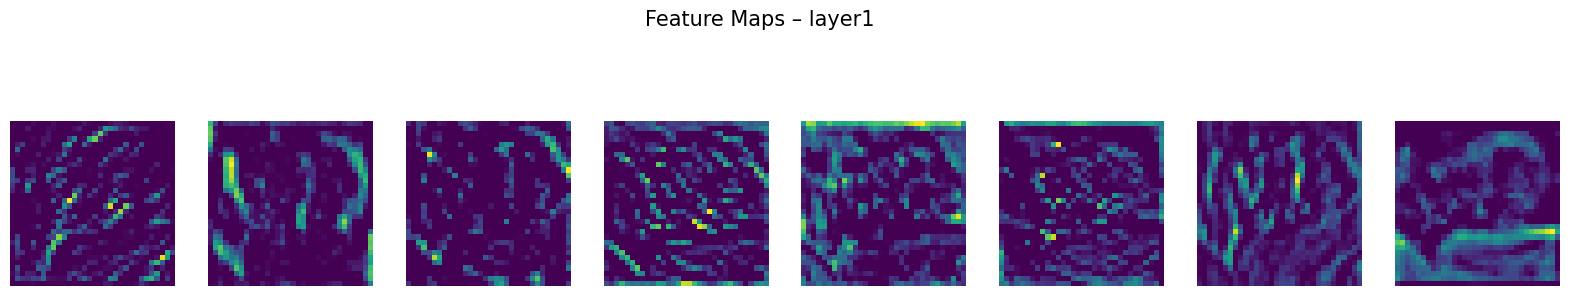

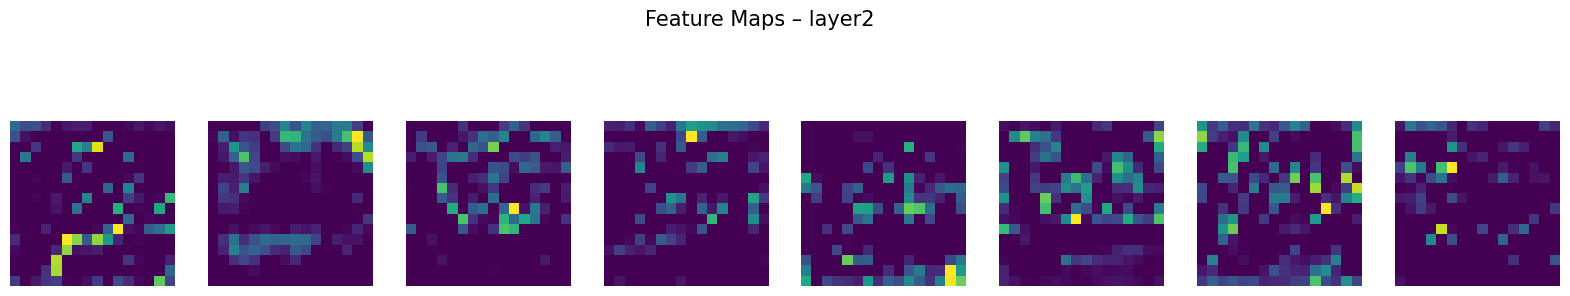

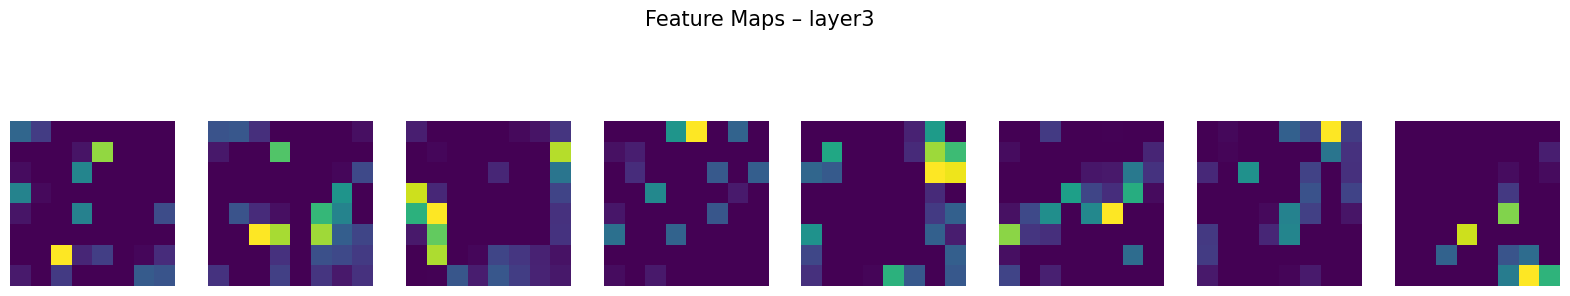

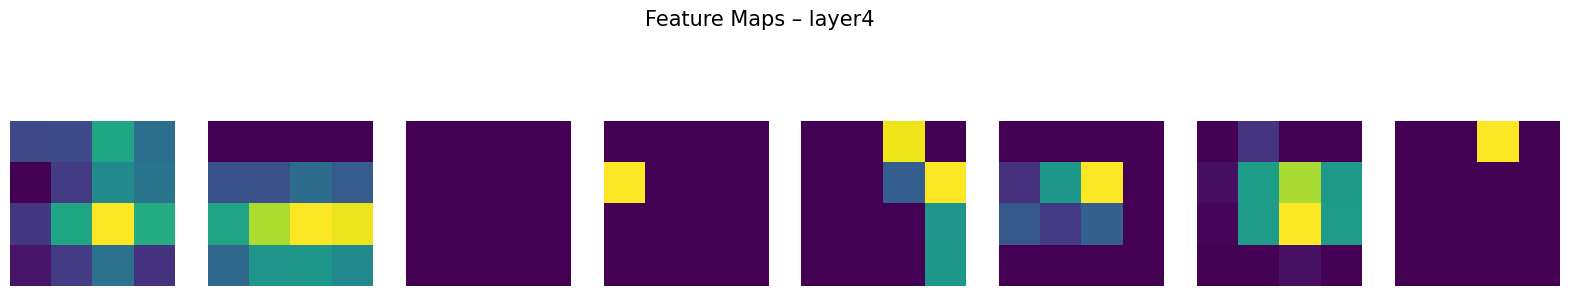

In [ ]:
model = model_res_acc  #we found for the resnet models, accuracy performed best so we choose to use this for our visualisations.
model.eval()

layers_to_hook = ["conv1", "layer1", "layer2", "layer3", "layer4"]
activations = {}

def hook_fn(name):
    def hook(module, input, output):
        activations[name] = output.detach().cpu()
    return hook
for name, module in model.named_modules():
    if name in layers_to_hook:
        module.register_forward_hook(hook_fn(name))
dataiter = iter(testloader)
img, label = next(dataiter)#we use one batch
img = img[0].unsqueeze(0).to(device) #1st image

with torch.no_grad():
    _ = model(img)

def plot_featuremaps(act, layer_name, num=8):
    act = act[0, :num]
    fig, axes = plt.subplots(1, num, figsize=(20, 4))
    fig.suptitle(f"Feature Maps – {layer_name}", fontsize=15)

    for i, ax in enumerate(axes):
        ax.imshow(act[i], cmap="viridis")
        ax.axis("off")
    plt.show()

for layer in layers_to_hook:
    plot_featuremaps(activations[layer], layer)

As an investigation into robustness, we consider how the ResNet18 model processes an image at each stage of its architecture as this will help us to better understand why the model behaves in a specific way to different image corruptions. In our visualisation, each row contains the first 8 channels from a particular layer from an image from CIFAR-10, where we have applied ResNet18_best_acc as this performed better than the ResNet18_best_loss. As we work through the layers we see that each layer focuses on a different aspect of the image.

The first layer we have displayed, conv1 of our feature map, looks smooth and is the closest resemblance to our original images. It captures very low level features such as edges within our images, gradients and colour transitions. In terms of our image corruption, this could be most affected by noise and blur as these will make it harder for the model to identify very low level features.

The next layer, layer1, appears to be slightly more abstract than the previous layer. This builds on conv1 by capturing low-level features and fine-grained textures such as repeated patterns, small curves and local motifs.  
Layer2 looks more fragmented as the model tries to understand shapes and object parts such as corners or curves. In terms of our robustness tests, gaussian blur and pixelation may make it harder for the model to identify objects.  Corruptions such as gaussian blur may affect these layers, as they disrupt they make the object harder to identify through spatial distortion.

The next layer, layer3, appears much more pixelated. At this level, blur and noise are less likely to affect the image as it is looking at the general structure of the image rather than the finer details.
The final layer we have visualised captures very high-level, class specific features.  This won’t be affected by smaller detail corruptions such as blur, but will be affected by corruptions that affect the image as a whole such as severe fog or frost.

This exploration into the feature layers has allowed us to learn more about how our CNNs work and how they are likely to behave when faced with different image corruptions.

# Parallelism and Scalability

## Parallelism
Parallelism is the concept of performing many computations at the same time, rather than one after another. A CPU usually has a small number of powerful cores, which are great at handling tasks sequentially, one step at a time. A GPU has thousands of smaller cores that are designed to do many calculations simultaneously. Each core can handle part of a large computation. So when tasks can be parallelised, such as processing many pixels or features in an image, the GPU can complete them much faster than a CPU. We used CUDA through PyTorch, which automatically manages computations on the GPU by splitting them into many small tasks called threads, allowing operations such as convolutions, pooling, and matrix multiplications to be executed simultaneously.

This parallelism is particularly important for CNNs, which perform a large number of operations across multiple layers and channels. Each convolution involves many operations that can be done at the same time. On a CPU, these would be executed sequentially, making the process very slow for deep networks or large images. GPUs allow these operations to happen in parallel, computing outputs for multiple pixels, channels, and filters at once. This drastically reduces training time, enables more experiments to run, and makes it possible to scale to deeper networks and larger datasets.


## Scalability
Throughout this project we have scaled what we learnt on our smaller toy dataset, CIFAR-10, to a more deployable, real-world dataset, Food101.  We have assessed how different model architectures perform on these and evaluated their robustness on corrupted images.
However, if we were to increase the data volume by a factor of 1000, this would require a change in the way we trained our models, since these already took approx 18h to run for each model. This means we would require more GPUs to train on large datasets and some alterations to our strategies. We would require access to high-performance computing resources such as multi-core GPUs and distributive training clusters.

In industry settings, data parallelism allows large training batches to be split across multiple devices, increasing throughput, as discussed in the section above. One of our models, the Vision Transformer, benefits particularly strongly from multi-GPU setups because its attention layers involve large matrix multiplications that scale linearly with available parallel compute. As we discussed, CNNs are also very parallelisable, since convolutions can be processed in parallel over batches and channels. This means our model architectures are well suited to benefit efficiently from additional resources.

Our models (ResNet and SLViT) already use mini-batch stochastic gradient descent, meaning that the training algorithm naturally scales to large datasets since we stream our data in batches rather than all at once into memory.
We used a transfer learning approach for some of our models, this means feature extraction uses pre-trained knowledge. This would dramatically reduce training complexity as it would only require adjusting the final layers and fine-tuning selectively, meaning our methods would scale very well.

We used PyTorch data loaders throughout our models, these are already compatible with distributed training since they support the use of multi-core workers. Therefore, our model architecture could be easily extended to multi-node frameworks such as PyTorch Distributed or Horovod without redesign.

The architectures we chose were originally designed for industrial-scale datasets, and we had to adjust these frameworks to work for our lower resolution images. ResNet18 was already trained on ImageNet (1.2 million high-res images with 1000 classes), and Vision Transformers were trained on  JFT-300M which is even larger, and therefore likely to scale even better than the ResNet architecture. A larger amount of data often improves ViT performance, as they are provided with more information to train on.

At a larger scale, we could improve memory efficiency by using approaches such as mixed-precision training and gradient checkpointing. With larger datasets we also introduce the issue of storage speed and loading time also becoming limiting factors, so by using faster SSDs or cloud-based storage systems, we could keep training efficient.

For our robustness tests, these wouldn’t need to change as these can already be scaled to datasets of larger volume , these corruptions were representative of real-world image scenarios.

For t-SNE and PCA, these were interesting to explore on smaller datasets where we have a small number of classes, however if we were to scale these to cases where we had over 1000 times more data and 101 classes for food101, it would be difficult to use these visualisations, so would have to find other ways to demonstrate feature extraction.




# Discussion

Overall, we have compared the performance of different model architectures including ResNet18, SLViT and Plain18. We have then implemented different training strategies including feature-extraction, fine-tuning, training from scratch and transfer learning.

Across CIFAR-10 and Food-101, convolutional models such as Resnet 18 and Plain 18 consistently demonstrate a better performance in terms of test loss and test accuracy than ViTs when data are limited or backbone is frozen (feature extraction). When trained from scratch, both CNNs converge quickly and achieve stable accuracy, while ViT learns more slowly and shows pronounced overfitting.

Under transfer learning on CIFAR-10, ViT becomes highly competitive, achieveing over 95% accuracy, yet still exhibits overfitting, while Resnet 18 fine-tuning improves steadily and may surpass ViT with additioanl training. On Food-101, pretrained Resnet 18 out perform ViT via feature extraction, it is unclear as to why this is the case. One potential reason may be to do with hyper parameter tuning.

In terms of robustness, we saw that SLViT was consistently more robust than ResNet18 across nearly all image corruptions for both CIFAR-10 and Food101. This shows that it provides stronger resilience to real-world corruptions and is a more robust method on the Food101 dataset.

In terms of scalability, thsi suggests that if we were to scale to more corrupt real-world images, SLViT is expected to perform better and maintain stronger generalisation properties and relatively high accuracy.

Finally, it is worth noting that the Model performance is limited by restricted training time, which prevented optimal hyperparameter tuning and many models are omitted from testing on food-101 as one epoch can take up to 20 minutes to train as a result. ViT in particular could benefit from deeper or gradual unfreezing

# References


**[1]** Bossard, L., Guillaumin, M., & Van Gool, L. (2014). *Food-101 – Mining Discriminative Components with Random Forests*.  
European Conference on Computer Vision.  
Available at: https://link.springer.com/chapter/10.1007/978-3-319-10599-4_29

**[2]** Rusiecki, A. (2022). Batch Normalization and Dropout Regularization in Training Deep Neural Networks with Label Noise. In: Abraham, A., Gandhi, N., Hanne, T., Hong, TP., Nogueira Rios, T., Ding, W. (eds) Intelligent Systems Design and Applications. ISDA 2021. Lecture Notes in Networks and Systems, vol 418. Springer, Cham. https://doi.org/10.1007/978-3-030-96308-8_6

**[3]** Kumar, V., Shukla, S., & Agarwal, A. (2025). *Robustness Benchmarking of Convolutional and Transformer Architectures for Image Classification*.  
IEEE Transactions on Big Data, 11(6), 3330–3341.  
DOI: 10.1109/TBDATA.2025.3593385  
Available at: https://ieeexplore.ieee.org/abstract/document/11098661  

**[4]** He, K., Zhang, X., Ren, S., & Sun, J. (2015). *Deep Residual Learning for Image Recognition*.  
arXiv preprint arXiv:1512.03385.  
Available at: https://arxiv.org/pdf/1512.03385  

**[5]** Baez, J. C. (2025). *What is Entropy?*  
arXiv preprint arXiv:2409.09232.  
Available at: https://arxiv.org/abs/2409.09232  


**[6]** Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, L., & Polosukhin, I. (2017).  
*Attention Is All You Need*.  
arXiv preprint arXiv:1706.03762.  
Available at: http://arxiv.org/abs/1706.03762  


